# **BBC News Classification and Labelling**

 - Ashswin Subbiah, Lu Li, Chang Sun




# **1. Introduction**

Text is the richest source of data. Manually reading through texts and extracting information from tons of texts are both time-consuming and labor-consuming. Unlike structured data, text has nature of sequence and semantics, making text related automation hard and different. Thanks to Natural Language Processing, we have a variety ways to extract insights or automate text sorting. In this project, we'll explore a variety of supervised and unsupervised methods to classify BBC news based on their topics.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Dataset**

"BBC Full Text Document Classification dataset" is collected from Kaggle's website (https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification).
Dataset was originally published in "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006 from D. Greene and P.Cunningham.
This dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from year 2004-2005 including: Business, Entertainment, Politics, Sport, Tech.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Import relevent libraries:

In [ ]:
%pip install icecream

In [ ]:
import glob
import operator
import pandas as pd
from time import time
import seaborn as sns
from icecream import ic
from pprint import pprint
import matplotlib.pyplot as plt
from collections import  Counter
from wordcloud import WordCloud, STOPWORDS

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import RegexpTokenizer, word_tokenize


from functools import reduce

import numpy as np
from numpy.lib.function_base import average

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Load data:

In [ ]:
df=pd.DataFrame(columns=['text','category'])
cates=['business', 'entertainment','politics','sport','tech']
texts=[]
labels=[]
for cate in cates:
  path=f"/content/drive/MyDrive/Colab Notebooks/Data607Project/Data/bbc-fulltext (document classification)/bbc/{cate}/"
  files = glob.glob(path+'*.txt')
  for file in files:
    with open(file,encoding='utf-8',errors='ignore') as f:
      text = f.read()
      texts.append(text)
      labels.append(cate)
df['text']=texts
df['category']=labels
df.head()


,text,category
0,Japan narrowly escapes recession\n\nJapan's ec...,business
1,India's rupee hits five-year high\n\nIndia's r...,business
2,Ad sales boost Time Warner profit\n\nQuarterly...,business
3,Air passengers win new EU rights\n\nAir passen...,business
4,China keeps tight rein on credit\n\nChina's ef...,business


# **3. Data Description** 

In [ ]:
df.category.unique() # 5 categories are there

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [ ]:
df.isnull().sum() # there is no null value

text        0
category    0
dtype: int64

There is no missing value in the dataset.

In [ ]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

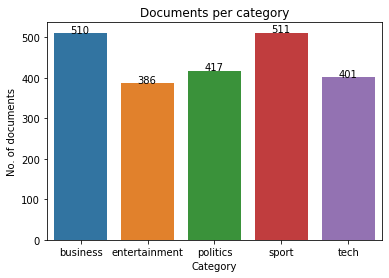

In [ ]:
# count plot (documents per category)
ax=sns.countplot(x ='category', data = df)
plt.title('Documents per category')
plt.xlabel('Category')
plt.ylabel('No. of documents')

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.5))

News content falls into 5 categories i.e 'Business','Entertainment','Politics','Sport', and 'Tech'. News distribution among topics are balanced, business and sports categories have slightly more news (510 and 511 respectively).


Word clouds is a visualization technique widely used for analyzing, and visualizing the data from social network websites.
 The size of each word represents it's frequency or importance. Word cloud is created below for every text category. Stop words should be removed to avoid unnecessary words in the Worldcloud

In [ ]:
#stop words
stop=set(stopwords.words('english'))
stop.update(["said", "also", "one", "could", "would","the","but","people","Mr","Say"]) 

In [ ]:
# create paragraph of sentences related to each category
Tech = ' '.join(list(df.text[df.category == 'tech']))
Business = ' '.join(list(df.text[df.category == 'business']))
Sports = ' '.join(list(df.text[df.category == 'sport']))
Entertainment = ' '.join(list(df.text[df.category == 'entertainment']))
Politics = ' '.join(list(df.text[df.category == 'politics']))

In [ ]:
from wordcloud import WordCloud
#remove the stop words
def wordcloud(text, title):
    
    wordcloud = WordCloud(
        width = 1500,
        height = 1000,
        background_color = "black",
        stopwords = stop,
        min_font_size = 10
    ).generate(text)

    plt.figure(figsize = (16, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.title("Word Cloud for " + title + " Articles\n", fontsize = 20)
    plt.axis("off")
    plt.show()

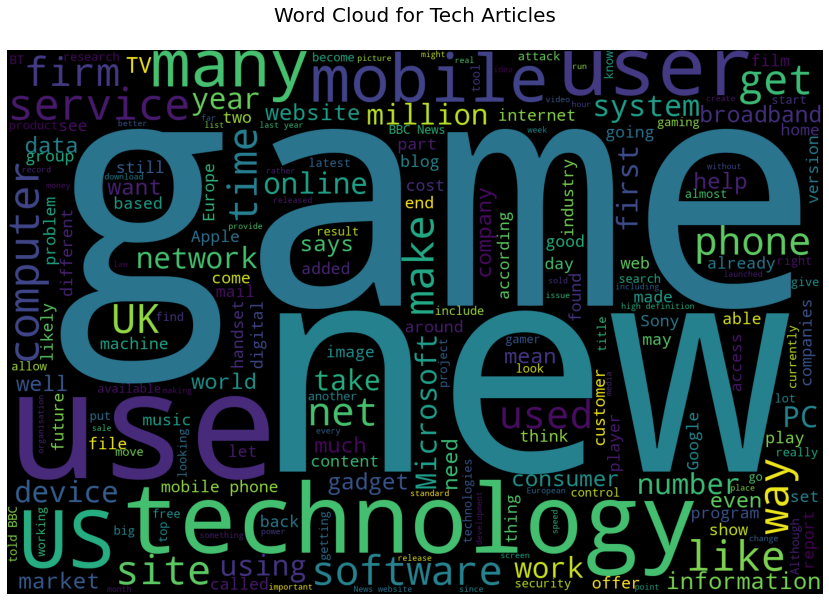

In [ ]:
wordcloud(Tech, "Tech")

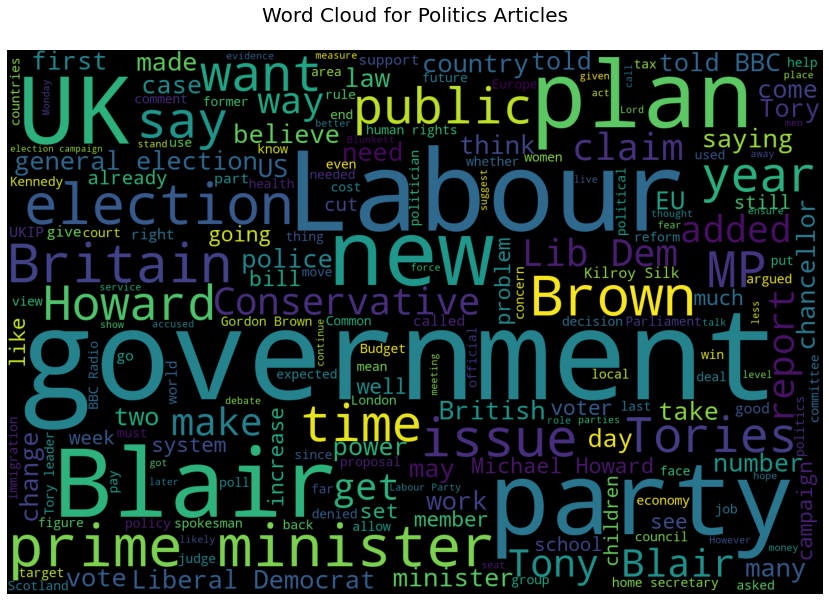

In [ ]:
wordcloud(Politics, "Politics")

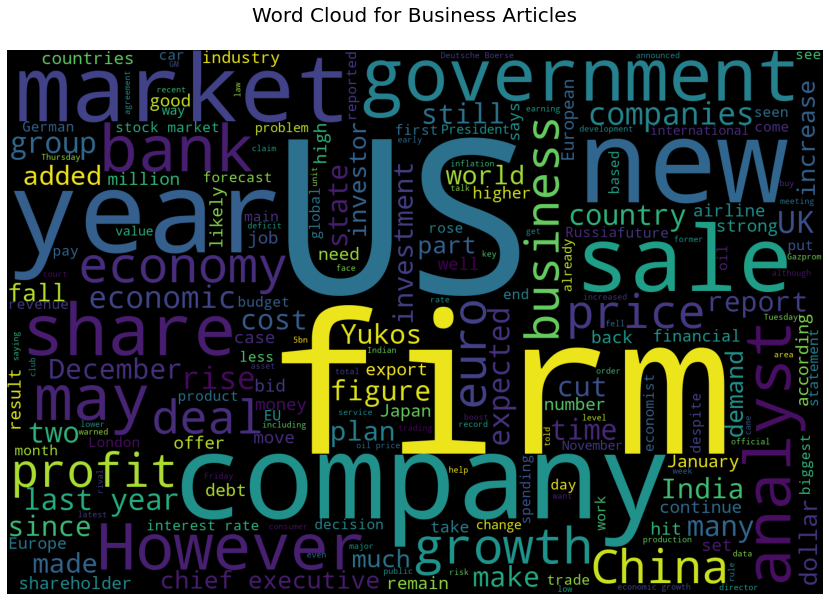

In [ ]:
wordcloud(Business, "Business")

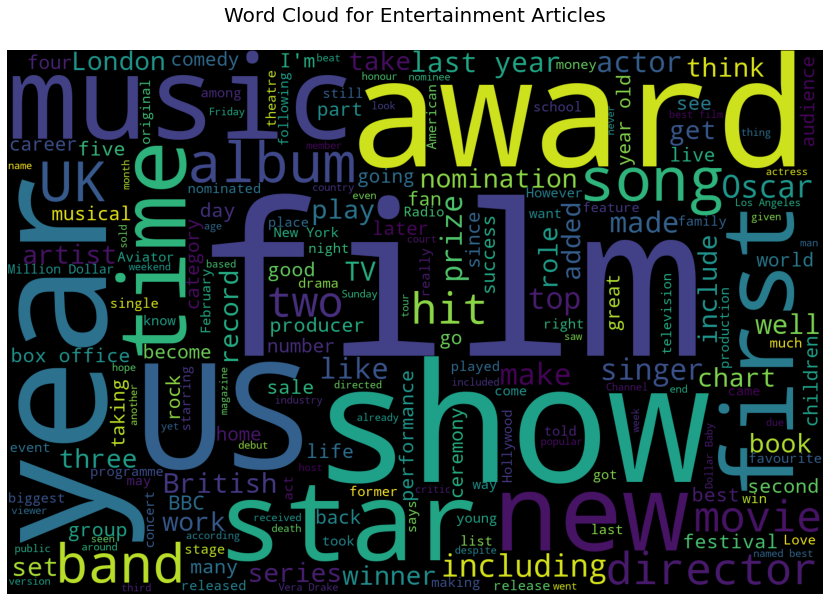

In [ ]:
wordcloud(Entertainment, "Entertainment")

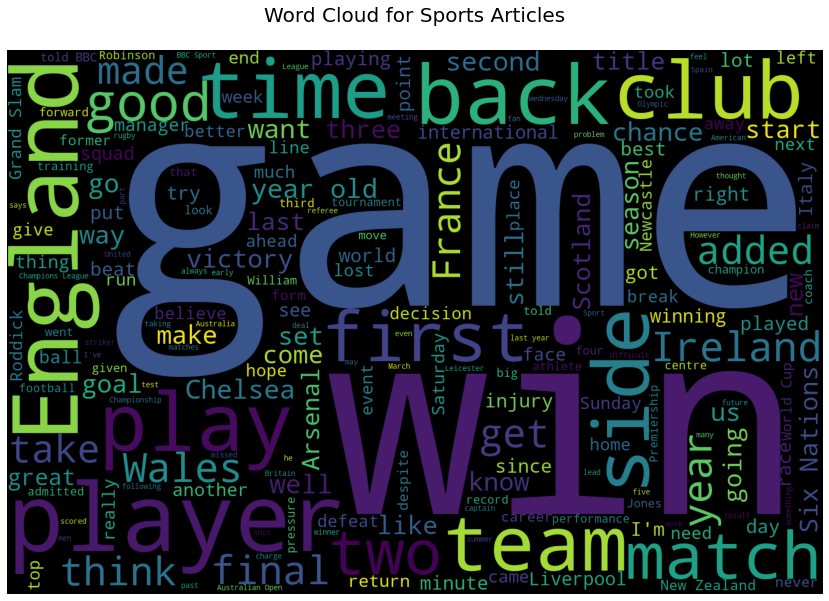

In [ ]:
wordcloud(Sports, "Sports")

After removing the stop words,

Word Cloud for tech category, the words game, new, technology, and mobile are frequent.

Word Cloud for politics-related articles, the words labor, government, party, Blair, and prime minister are frequent.

Word Cloud for business-related articles, the words  US, Firm, company, market, and sale are frequent.

Word Cloud for sport-related articles, the words game, win, player, match, and team, are frequent.

Word Cloud for entertainment-related articles, the words film, show, music, award, and the band are frequent.



Data has been cleaned for further operations. Stop words, all numbers, punctuation, and special character are removed below. Lemmatization is also performed (the process of grouping words together with similar meanings to one word). Lemmatization is similar to stemming but it brings context to the words. It is preferred over Stemming because lemmatization does morphological analysis of the words.

In [ ]:
# DATA CLEANING
print('Data cleaning has been started...')
import re
# Tokenize
df['text_clean'] = df['text'].apply(nltk.word_tokenize)
print('Tokenization done.')

# Remove stop words
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if item not in stop])
print('Stop words are removed from text.')

# (only keep words)
regex = '[a-z]+'
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('all Numbers, punctuation and special characters are removed.')

# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization is done.\nData cleaning is cleaned now .\n')

Data cleaning has been started...
Tokenization done.
Stop words are removed from text.
all Numbers, punctuation and special characters are removed.
Lemmatization is done.
Data cleaning is cleaned now .



In [ ]:
df.head(5)

,text,category,text_clean
0,China keeps tight rein on credit\n\nChina's ef...,business,"[keep, tight, rein, credit, efforts, stop, eco..."
1,"India calls for fair trade rules\n\nIndia, whi...",business,"[call, fair, trade, rule, attend, meet, seven,..."
2,Dollar gains on Greenspan speech\n\nThe dollar...,business,"[gain, speech, dollar, hit, highest, level, eu..."
3,"Parmalat boasts doubled profits\n\nParmalat, t...",business,"[boast, double, profit, food, group, centre, p..."
4,High fuel prices hit BA's profits\n\nBritish A...,business,"[fuel, price, hit, profit, blame, high, fuel, ..."


In [ ]:
for text_, tokens_ in zip(df['text'].head(5), df['text_clean'].head(5)):
    print('whole_text:', text_)
    print('tokens_:', tokens_)
    print()

whole_text: China keeps tight rein on credit

China's efforts to stop the economy from overheating by clamping down on credit will continue into 2005, state media report.

The curbs were introduced earlier this year to ward off the risk that rapid expansion might lead to soaring prices. There were also fears that too much stress might be placed on the fragile banking system. Growth in China remains at a breakneck 9.1%, and corporate investment is growing at more than 25% a year. The breakneck pace of economic expansion has kept growth above 9% for more than a year. Rapid tooling-up of China's manufacturing sector means a massive demand for energy - one of the factors which has kept world oil prices sky-high for most of this year. In theory, the government has a 7% growth target, but continues to insist that the overshoot does not mean a "hard landing" in the shape of an overbalancing economy. A low exchange rate - China's yuan is pegged to a rate of 8.28 to the dollar, which seems to b

In [ ]:
# top 10 keywords from each category after cleaning the data
def keywords_(category):
    tok = df[df['category'] == category]['text_clean']
    all_token = []
    for token_l in tok:
        all_token += token_l
    counter = Counter(all_token)
    return counter.most_common(10)

for category in set(df['category']):
    print('category :', category)
    print('top 10 keywords:', keywords_(category))
    print('---')

category : tech
top 10 keywords: [('use', 950), ('game', 817), ('make', 612), ('phone', 534), ('technology', 486), ('get', 478), ('new', 469), ('service', 468), ('mobile', 412), ('firm', 386)]
---
category : entertainment
top 10 keywords: [('film', 842), ('best', 550), ('show', 441), ('star', 398), ('award', 371), ('music', 362), ('year', 351), ('include', 332), ('make', 322), ('take', 320)]
---
category : sport
top 10 keywords: [('play', 616), ('game', 607), ('win', 585), ('go', 517), ("n't", 503), ('take', 457), ('get', 453), ('make', 452), ('first', 430), ('time', 381)]
---
category : business
top 10 keywords: [('year', 626), ('company', 610), ('firm', 551), ('market', 522), ('rise', 445), ('price', 388), ('growth', 362), ('economy', 349), ('make', 349), ('share', 329)]
---
category : politics
top 10 keywords: [('government', 701), ('say', 649), ('party', 564), ('election', 547), ('make', 473), ('plan', 464), ('minister', 436), ('tell', 417), ('go', 371), ('tax', 357)]
---


The above output represents top 10 keywords (the most common) from each BBC news category.


# **4. Texts Classification - Supervised Learning**

This task is split into two parts: 

Classification with variety of machine learning algorithms in Scikit-Learn

Classification with Word2Vec + Recursive Neural Network 

## 4.1 Machine Learning Models (Scikit-Learn)

The dataset is proportionally stratified using a startified training: test ratio of 0.8: 0.2.

In [ ]:
#proprotional stratified sampling of the relatively balanced dataset
Xtr_a, Xte_a, ytr_a, yte_a = train_test_split(df.text, df.category,stratify = df.category, test_size=0.2, random_state=100)
ic(ytr_a.value_counts(), yte_a.value_counts())
ic(Xtr_a.head(2), ytr_a.head(2))

ic| ytr_a.value_counts(): sport            409
                          business         408
                          politics         333
                          tech             321
                          entertainment    309
                          Name: category, dtype: int64
    yte_a.value_counts(): business         102
                          sport            102
                          politics          84
                          tech              80
                          entertainment     77
                          Name: category, dtype: int64
ic| Xtr_a.head(2): 284     Iraqi voters turn to economic issues
                   
                   Beyond...
                   1024    Green fear for transport ballot
                   
                   The Green P...
                   Name: text, dtype: object
    ytr_a.head(2): 284     business
                   1024    politics
                   Name: category, dtype: object


(284     Iraqi voters turn to economic issues\n\nBeyond...
 1024    Green fear for transport ballot\n\nThe Green P...
 Name: text, dtype: object, 284     business
 1024    politics
 Name: category, dtype: object)

### 4.1.1 Vectorization

For the supervised scikit learn models, the order of the words do not matter unlike sentimental analysis. As such the two types of frequency based transformers: count-vectorizer and tf-idf vectorizer are used to convert a collection of text documents to a matrix of token counts. 

In [ ]:
counter = CountVectorizer(stop_words="english", strip_accents= ascii)
doc_term_matrix_tr = counter.fit_transform(Xtr_a) #fitting and trasnform to the data - this is the training version 
doc_term_matrix_te = counter.transform(Xte_a) #We just trasnform the testing data 
ic(doc_term_matrix_tr, doc_term_matrix_te);

tfidf_counter = TfidfVectorizer(stop_words="english", strip_accents= ascii)
doc_term_matrix_tr_tfidf = tfidf_counter.fit_transform(Xtr_a)

tf_idf_word_array = tfidf_counter.get_feature_names_out()
count_vec_word_array = counter.get_feature_names_out()


ic| doc_term_matrix_tr: <1780x28657 sparse matrix of type '<class 'numpy.int64'>'
                        	with 264141 stored elements in Compressed Sparse Row format>
    doc_term_matrix_te: <445x28657 sparse matrix of type '<class 'numpy.int64'>'
                        	with 61986 stored elements in Compressed Sparse Row format>


In [ ]:
count_list_vec = doc_term_matrix_tr.toarray().sum(axis=0)
count_list_tfidf = doc_term_matrix_tr_tfidf.toarray().sum(axis =0)

count_vec_matrix = {"Word": count_vec_word_array,"Frequency": count_list_vec}
count_vec_df = pd.DataFrame(count_vec_matrix).sort_values('Frequency', ascending = False)

tfidf_vec_matrix = {"Word": tf_idf_word_array,"Frequency": count_list_tfidf}
tfidf_vec_df = pd.DataFrame(tfidf_vec_matrix).sort_values('Frequency', ascending = False)

print (pd.concat([
    count_vec_df.reset_index(drop=1).add_suffix('_1').head(10),
    tfidf_vec_df.reset_index(drop=1).add_suffix('_2').head(10)
  ], axis=1).fillna(''))

       Word_1  Frequency_1      Word_2  Frequency_2
0        said         5804        said    67.965610
1          mr         2241          mr    42.557565
2        year         1860        year    32.844990
3        nthe         1682      people    28.934272
4      people         1623         new    26.861861
5         new         1538        nthe    25.373250
6        time         1080        film    23.481173
7       world          928  government    21.630205
8  government          905       world    20.949951
9          uk          850        time    20.896509


It can be observed that the frequency count for the Count Vecotrizer and the Tfidf vecotrizer are a lot different. 

This is simply because Tf-idf gives the ratre term a higher weight and the common term a lower weight, making it a more robust trasnformer and a better pick over Count Vectorizer. 

### 4.1.2 Base model: Non- ensemble classifiers

**General note for all scikit learn classifiers**: The model is as good as the loss function and the accuracy metric one selects.

**Non-ensemble classifiers - Base Model selection**

A non-ensemble classifier is selected by grid searching the best non-ensemble: transformer combination. 

Please note that, in order ot be able to compare all supervised scikit learn models against each other, the number of features are limited to 100 and not hyperparameter tuned. 

For the base model alone, no hyperparameters were tuned.

In [ ]:
#initilaizing a pipeline with logistic regression estimator and count vectorizer transfomer 
pipe_a = Pipeline(steps = [("vectorization", CountVectorizer(stop_words="english", strip_accents= ascii, max_features = 100)), ("classifier", LogisticRegression())]) #initiate pipeline with random classifier 

#Dictionary containing hyperparameters that are to be tuned 

classifier_type = [{"classifier": [MultinomialNB()],
                    "vectorization": [CountVectorizer(max_features = 100)]},
                   {"classifier": [MultinomialNB()],
                    "vectorization": [TfidfVectorizer(max_features = 100)]},
                   {"classifier": [SVC()],
                    "vectorization": [TfidfVectorizer(max_features = 100)]},
                   {"classifier": [SVC()],
                    "vectorization": [CountVectorizer(max_features = 100)]},
                   {"classifier": [KNeighborsClassifier()],
                    "classifier__n_neighbors": [5],
                    "vectorization": [CountVectorizer(max_features = 100)]},
                   {"classifier": [KNeighborsClassifier()],
                    "classifier__n_neighbors": [5],
                    "vectorization": [TfidfVectorizer(max_features = 100)]},
                   {"classifier": [ LogisticRegression()],
                    "vectorization": [CountVectorizer(max_features = 100)]},
                   {"classifier": [ LogisticRegression()],
                    "vectorization": [TfidfVectorizer(max_features = 100)]}
                   ]

grid_classifier = GridSearchCV(estimator = pipe_a, param_grid = classifier_type, cv = 3, return_train_score= True, n_jobs = -1, verbose=1) #return train score
best_classifier = grid_classifier.fit(Xtr_a, ytr_a)
Nonensemble_model_result = pd.DataFrame(best_classifier.cv_results_).sort_values('rank_test_score', ascending = True)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
Nonensemble_model_result.head(5)
#BaseModel: SVC estimator with CountVectorizer transformer has the best score of all the non-ensemble technique

ic| accuracy_score(grid_classifier.best_estimator_.predict(Xte_a), yte_a): 0.8606741573033708


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_vectorization,param_classifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,1.308835,0.023816,0.624203,0.005752,SVC(),TfidfVectorizer(max_features=100),NaN,"{'classifier': SVC(), 'vectorization': TfidfVe...",0.828283,0.851602,0.846543,0.842143,0.010016,1,0.929174,0.925021,0.923336,0.925844,0.002453
7,0.840915,0.008857,0.282138,0.018993,LogisticRegression(),TfidfVectorizer(max_features=100),NaN,"{'classifier': LogisticRegression(), 'vectoriz...",0.799663,0.822934,0.826307,0.816301,0.011845,2,0.862563,0.846672,0.850042,0.853093,0.006837
0,0.870045,0.187682,0.329771,0.048759,MultinomialNB(),CountVectorizer(max_features=100),NaN,"{'classifier': MultinomialNB(), 'vectorization...",0.809764,0.812816,0.809444,0.810675,0.001520,3,0.833895,0.825611,0.807077,0.822194,0.011212
6,0.969168,0.011393,0.273394,0.008068,LogisticRegression(),CountVectorizer(max_features=100),NaN,"{'classifier': LogisticRegression(), 'vectoriz...",0.787879,0.809444,0.821248,0.806190,0.013816,4,0.961214,0.939343,0.919124,0.939894,0.017188
1,0.852422,0.252596,0.305606,0.043735,MultinomialNB(),TfidfVectorizer(max_features=100),NaN,"{'classifier': MultinomialNB(), 'vectorization...",0.776094,0.780776,0.768971,0.775280,0.004853,5,0.795953,0.786015,0.787700,0.789889,0.004342


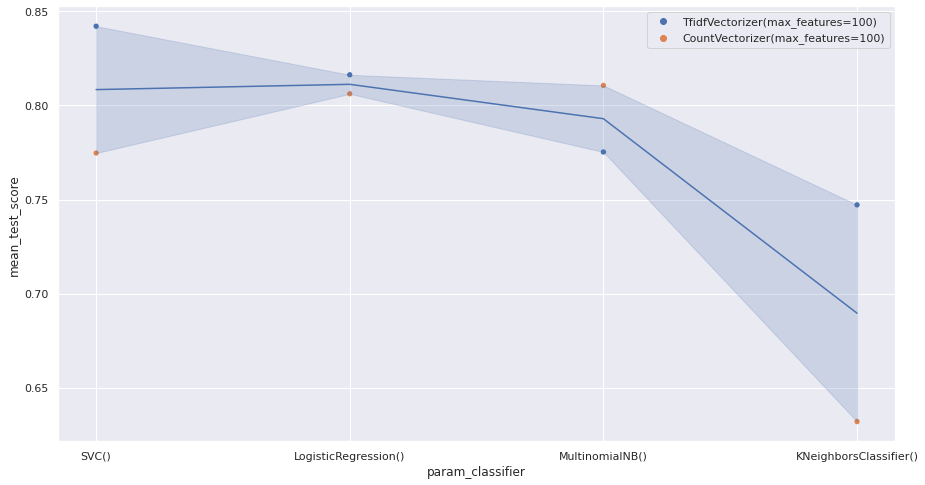

In [ ]:
Nonensemble_model_result.dtypes #param classifer and param vectorizer is of object type 
sns.scatterplot(x = Nonensemble_model_result.param_classifier.astype(str), y = "mean_test_score", hue= Nonensemble_model_result.param_vectorization.astype(str), data=Nonensemble_model_result )
sns.lineplot(x = Nonensemble_model_result.param_classifier.astype(str), y = "mean_test_score", data=Nonensemble_model_result )
plt.show()

In [ ]:
ic(accuracy_score(grid_classifier.best_estimator_.predict(Xte_a), yte_a))
print(grid_classifier.best_params_)

ic| accuracy_score(grid_classifier.best_estimator_.predict(Xte_a), yte_a): 0.8606741573033708


{'classifier': SVC(), 'vectorization': TfidfVectorizer(max_features=100)}


**Conclusion on Base Model Hyperparameter Tuning graph**

From the graph above we can decude that the the SVC with rbf kernel and the TFIDF combination results in the best base model with the lowest mean test score. The Accuracy score for this classifier is 0.86. 

Text(0.5, 0, 'Permutation Importance')

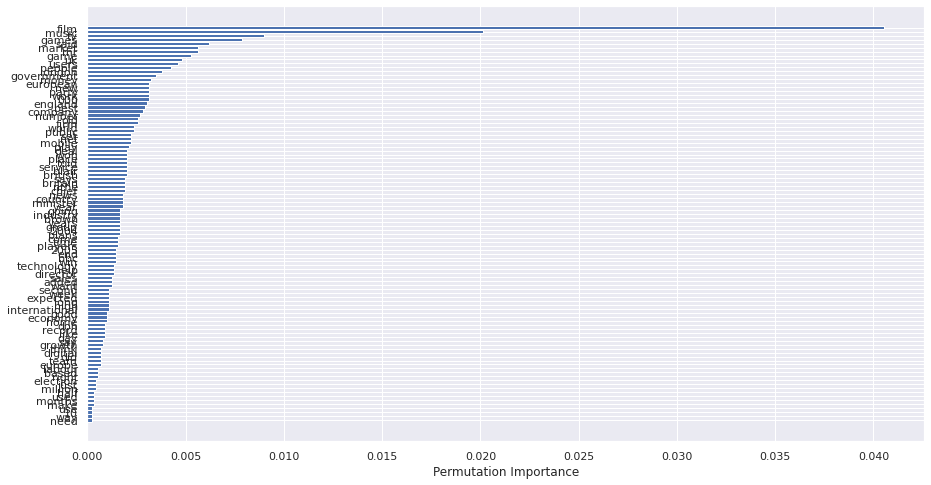

In [ ]:
from sklearn.inspection import permutation_importance
Tfidf_gbc = TfidfVectorizer(stop_words="english", strip_accents= ascii, max_features= 100)
doc_t_matrix_tr = Tfidf_gbc.fit_transform(Xtr_a)

base_final_model = SVC().fit(doc_t_matrix_tr, ytr_a) #default for SVC is rbf, scale = 3, gamma = scale

perm_importance = permutation_importance(base_final_model, doc_t_matrix_tr.toarray(), ytr_a)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(Tfidf_gbc.get_feature_names_out()[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
data_base_model = {"Feature_Names": Tfidf_gbc.get_feature_names_out()[sorted_idx], 'Importance': perm_importance.importances_mean[sorted_idx]}
pd.DataFrame(data_base_model).sort_values('Importance', ascending = False).head(20)

,Feature_Names,Importance
99,film,0.040562
98,music,0.020112
97,tv,0.008989
96,games,0.007865
95,said,0.006180
94,market,0.005618
93,mr,0.005618
92,game,0.005281
91,uk,0.004831
90,users,0.004607


**Conclusion the final base model**

Just like the Random Forest model, the SVC with the rbf kernel can be treated as a black box. One way of getting insights into the the SVC with rbf kernel is to compute the permutation feature importance. 

The permutation feature importance is a technique for calcualting relative importance scores that is independent of the model used. The permutation feature process is the process of using the model to make predictions on the dataset with the scrambled value of feature is repeated a couple of times before taking a mean important score for each input feature. 

The top 3 features that reduces the impurity the highest predicted by the TfIDF:SVC combination is film at 4% and music at 2%.

### 4.1.3 Ensemble Classifier, Bagging - Random Forest Classifier


**Introduction to RFC and selected hyperparameters for tuning**

Random Forest is an extension of over bagging. In addition to taking radnom subsets of data, it also takes ramdomly selected features to grow the random trees. The predictions for all the created random decision trees are combined, resulting in lower error than fitting a single tree. 

RandomSearch CV was performed to obtain the ideal hyperparameter range for the imported dataset. 

The selected hyperparamerters that were randomly searched includes n_estimators, max depth, vect_ngram range and class weight. 

N_estimators: The number of trees in the forest

Max_depth: The nodes are extended till the maximum allowable depth of the tree

N-grams: N-grams were a hyperparameter that was tuned because some words make sense when they are chunked together for example "high school" or 'San Franciso". 

Class-weight: Eventhough the dataset is not highly unbalanced, the second hyperparamter that is to be tuned is class weight. Setting it to balance will result in the classes being weighted inversely proportional to how frequently they appear in the data. 



#### 4.1.3.1 Random Forest Regressor, Hyperparameter tuning with RandomSearchCV

In [ ]:
pipeline_RFC = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words="english", strip_accents= ascii, max_features = 100)),
        ("rfc", RandomForestClassifier()), #the default quality split measure is "gini", TALK ABOUT CLASS WEIGHT 
    ]
)

#n_estimators_rcv = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 13)]
#max_features_rcv = ['auto', 'sqrt']
n_estimators_rcv = [100, 300, 500, 1000]
max_depth_rcv = [3,7,9,12]

parameters_rcv = {
    #"vect__max_df": (0.5, 0.75, 1.0),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "rfc__class_weight": ["balanced", "balanced_subsample"], 
    "rfc__n_estimators": n_estimators_rcv, 
    "rfc__max_depth" : max_depth_rcv
}

rf_random_search = RandomizedSearchCV(estimator = pipeline_RFC, param_distributions = parameters_rcv, n_iter = 100, cv = 3, verbose=2, random_state=29, n_jobs = -1)

print("Performing random search...")
print("pipeline:", [name for name, _ in pipeline_RFC.steps])
print("parameters:")
pprint(parameters_rcv)
t0 = time()
rf_random_search.fit(Xtr_a, ytr_a)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % rf_random_search.best_score_)
print("Best parameters set:")
best_parameters_rcv = rf_random_search.best_estimator_.get_params()

Performing random search...
pipeline: ['vect', 'rfc']
parameters:
{'rfc__class_weight': ['balanced', 'balanced_subsample'],
 'rfc__max_depth': [3, 7, 9, 12],
 'rfc__n_estimators': [100, 300, 500, 1000],
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 64 candidates, totalling 192 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 64 is smaller than n_iter=100. Running 64 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


done in 420.535s

Best score: 0.900
Best parameters set:


In [ ]:
rfc_results = pd.DataFrame(rf_random_search.cv_results_) #[['params', 'mean_test_score', 'rank_test_score']]
rfc_results.sort_values(['rank_test_score'],ascending=[True]).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vect__ngram_range,param_rfc__n_estimators,param_rfc__max_depth,param_rfc__class_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
29,5.215098,0.187664,0.571030,0.018028,"(1, 2)",500,12,balanced,"{'vect__ngram_range': (1, 2), 'rfc__n_estimato...",0.898990,0.895447,0.905565,0.900001,0.004192,1
26,2.438193,0.049909,0.336976,0.025803,"(1, 1)",300,12,balanced,"{'vect__ngram_range': (1, 1), 'rfc__n_estimato...",0.892256,0.897133,0.905565,0.898318,0.005498,2
61,5.687080,0.032844,0.585473,0.005754,"(1, 2)",500,12,balanced_subsample,"{'vect__ngram_range': (1, 2), 'rfc__n_estimato...",0.892256,0.898820,0.902192,0.897756,0.004126,3
62,7.444754,0.109936,0.553197,0.036915,"(1, 1)",1000,12,balanced_subsample,"{'vect__ngram_range': (1, 1), 'rfc__n_estimato...",0.892256,0.895447,0.902192,0.896632,0.004142,4
63,8.233702,1.074955,0.605866,0.152231,"(1, 2)",1000,12,balanced_subsample,"{'vect__ngram_range': (1, 2), 'rfc__n_estimato...",0.892256,0.895447,0.900506,0.896070,0.003397,5


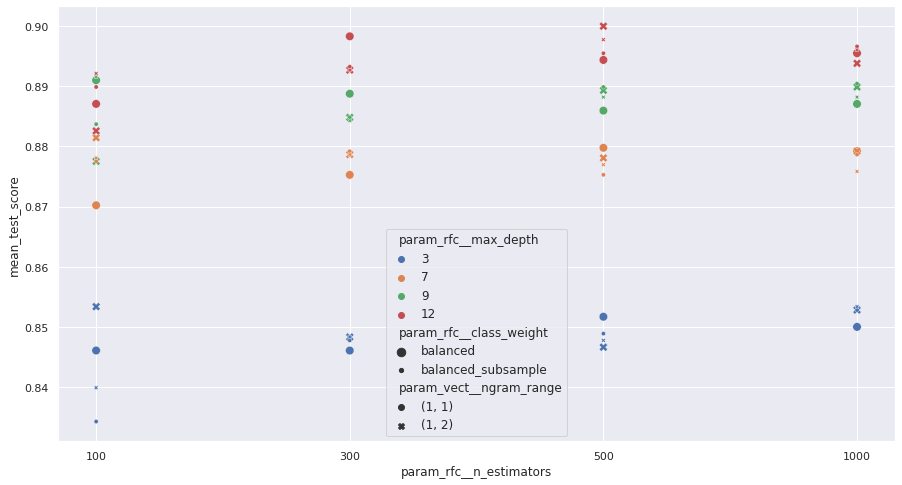

In [ ]:
rfc_results.dtypes #all the params are object type and they need to be converted to string 
sns.scatterplot(x = rfc_results.param_rfc__n_estimators.astype(str), y = "mean_test_score", hue = rfc_results.param_rfc__max_depth.astype(str), style = rfc_results.param_vect__ngram_range.astype(str), size = rfc_results.param_rfc__class_weight.astype(str), data=rfc_results) #use hue, syle, size for creating subsets of data
plt.show()

**Conclusion on the RandomSearch Hyperparameter tuning**

The above is a 2D graph showing the results of the randomsearch hyperparamter tuning computed on the random forest model. In general the random forest with 200 and 500 estimators with the max tree depth outperformed the other two model. 

Number of estimators & Tree depth observation: Relatively speaking increasing the tree depth improves the accuracy of the model by a greater percentage over increasing the number of estimators.

Class weight observation: Because the dataset is very balanced, initilizing the class weight to balanced and balanced subsample weight does not seem to make any difference.

N-gram range: It can be observed that there are equal occurences of n_gram 1,1 and 1,2 performing better than one another. There is no distinct improvement in considering ngram (1,2) over just tokenizing the corpus by 1 word.  

In conclusion, the random search CV indicates the best number of random forest estimators for this dataset is close to 500 and the depth range should be between 9 and 12. Gridsearch CV will now be performed on these two variables.

In [ ]:
ic(accuracy_score(rf_random_search.best_estimator_.predict(Xte_a), yte_a))
print(rf_random_search.best_params_)

ic| accuracy_score(rf_random_search.best_estimator_.predict(Xte_a), yte_a): 0.8966292134831461


{'vect__ngram_range': (1, 2), 'rfc__n_estimators': 500, 'rfc__max_depth': 12, 'rfc__class_weight': 'balanced'}


#### 4.1.3.2 Random Forest Regressor, Hyperparameter tuning with GridSearchCV

In [ ]:
#This is a pipeline with combining a text feature extractor with ONE classifier. 
pipeline_RFC = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words="english", strip_accents= ascii, ngram_range=(1,2), max_features = 100)),
        ("rfc", RandomForestClassifier(class_weight = "balanced")), #the default criterion for tree split is "gini"
    ]
)

# Number of trees in random forest
n_estimators = [400,500,600]
# Maximum number of levels in tree
max_depth = [10,11,12]

parameters = {
    "rfc__n_estimators": n_estimators,
    "rfc__max_depth": max_depth
}

grid_search_rdf = GridSearchCV(estimator = pipeline_RFC, param_grid = parameters, n_jobs=-1, verbose=1) #removed scoring = 'accuracy' , cv is 5 by default, default accuracy score is gini 

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_RFC.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search_rdf.fit(Xtr_a, ytr_a)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search_rdf.best_score_)
print("Best parameters set:")
best_parameters = grid_search_rdf.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'rfc']
parameters:
{'rfc__max_depth': [10, 11, 12], 'rfc__n_estimators': [400, 500, 600]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
done in 152.521s

Best score: 0.894
Best parameters set:
	rfc__max_depth: 12
	rfc__n_estimators: 600


In [ ]:
rdf_results = pd.DataFrame(grid_search_rdf.cv_results_).sort_values('rank_test_score', ascending = True)
rdf_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,6.202138,0.605096,0.368986,0.073409,12,600,"{'rfc__max_depth': 12, 'rfc__n_estimators': 600}",0.901685,0.893258,0.882022,0.898876,0.896067,0.894382,0.006788,1
6,6.223364,1.278193,0.375380,0.022023,12,400,"{'rfc__max_depth': 12, 'rfc__n_estimators': 400}",0.887640,0.896067,0.884831,0.898876,0.898876,0.893258,0.005892,2
7,5.886740,0.044994,0.379141,0.011533,12,500,"{'rfc__max_depth': 12, 'rfc__n_estimators': 500}",0.887640,0.887640,0.882022,0.904494,0.904494,0.893258,0.009401,2
5,6.391434,0.093365,0.409061,0.015167,11,600,"{'rfc__max_depth': 11, 'rfc__n_estimators': 600}",0.887640,0.890449,0.879213,0.901685,0.901685,0.892135,0.008631,4
0,5.866637,1.003810,0.354925,0.014699,10,400,"{'rfc__max_depth': 10, 'rfc__n_estimators': 400}",0.896067,0.882022,0.882022,0.898876,0.896067,0.891011,0.007411,5


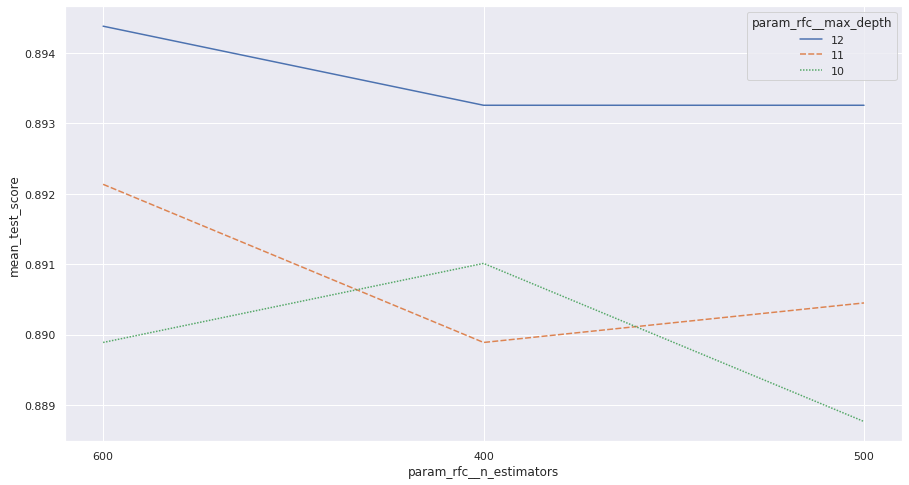

In [ ]:
rdf_results.dtypes #all the params are object type and they need to be converted to string 
sns.lineplot(x = rdf_results.param_rfc__n_estimators.astype(str), y = "mean_test_score", hue = rdf_results.param_rfc__max_depth.astype(str), style = rdf_results.param_rfc__max_depth.astype(str), data=rdf_results) #use hue, syle, size for creating subsets of data
plt.show()

In [ ]:
ic(accuracy_score(grid_search_rdf.best_estimator_.predict(Xte_a), yte_a))
print(grid_search_rdf.best_params_)

ic| accuracy_score(grid_search_rdf.best_estimator_.predict(Xte_a), yte_a): 0.9078651685393259


{'rfc__max_depth': 12, 'rfc__n_estimators': 600}


**Conclusion on the gridsearch CV hyperparameter tuning**

As expected, the number of estimators does not make much difference in the accuracy score relative to the tree depth. Accuracy improvements observed are in the range of three decimal places. Essentially the results from the random search suffice would have sufficed without computing the gridsearch Cv. 

However, the conclusion from the gridsearch cv is the number of random forest estimators that performs best is 600 with a max depth of 12. Using the best estimator, the achieved accuracy on the training set is 0.907. 

Feature importance of the Random Forest Classifier

,Feature_Names,Importance
29,film,0.063881
90,users,0.048554
35,government,0.045708
50,market,0.042887
82,technology,0.038973
31,game,0.035961
56,mr,0.033605
94,win,0.032795
45,labour,0.031799
57,music,0.030933


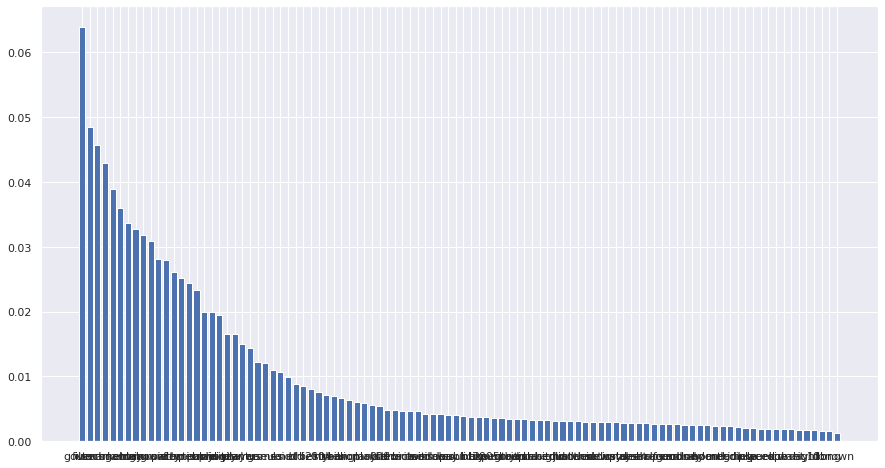

In [ ]:
Tfidf_gbc = TfidfVectorizer(stop_words="english", strip_accents= ascii, max_features= 100)
doc_t_matrix_tr = Tfidf_gbc.fit_transform(Xtr_a)
rfc_final_model = RandomForestClassifier(n_estimators=600, max_depth=12, random_state=29).fit(doc_t_matrix_tr, ytr_a)
rfc_feature_imp_df = pd.DataFrame({'Feature_Names': Tfidf_gbc.get_feature_names_out(), 'Importance': rfc_final_model.feature_importances_ }).sort_values(by = 'Importance', ascending = False)
plt.bar(rfc_feature_imp_df['Feature_Names'], rfc_feature_imp_df['Importance'])
rfc_feature_imp_df.head(20)

**Conclusion on the Final Random Forest Classifier** 

One of the many ways to un-black box the random forest model is by using the feature importance. For classification, the internal node is selected such that feature results in the highest decrease the gini impurity.

Decision trees algothims classifiers offer importance scorces based on the reduction in the criterion used to split points like Gini or entropy/deviance. Both deviance and entropy are the same.

Lining up the Tfidf feature names from the Tfidf Vectorizer and the feature importance from the Random Forest Classifier shows that film reduces the GIni imputiy by 6% followed by users at 4.8% and governemnet at 4.5%. This can also be absorbed in the vertical bar graph. 

Note that the impurity-based feature importances can be misleading for **high cardinality** features (many unique values). The impurity imporatances are computed on training set statistics. As such, they do not reflect the ability of feature to be useful to make predictions that generalize the test set.

**To address the high cardinlaity issue:** The predictive power of the random forest were tested with a held out set (could have done corss validation) prior to computing the importances. Accuracy on test set is at 0.907.

### 4.1.4 Ensemble Classifiers: Stochastic Gradient Boosting Classifier (deviance loss function)


**Introduction to Boosting**

The boosting ensemble technique incrimentally adds weak learners in a forward stage wise fashion while optimizing the arbritrary loss function. Multiple versions. 

The same training dataset is used to train each decision tree. No sampling performed unlike bagging based models. The rows that are easy to predict using the emsemble have small weight versus the rows that are difficult to predict will have larger weihgt. Decision tree is the base learner in GBC. 

The selected loss function for the multiclassifcation Gradient Boost Classifer is Deviance. The optimizer is gradient based. 

**Selected Boosting hyperparamter tuning**

Subsample: Stochastic gradient boosting impelemnted by introducing subsample parameter as part of the parameter grid in hyperparameter tuning. Choosing subsample < 1.0 leads to reduction of varaince and an increase in bias. 

Learning_rate: The learning rate shrink the contribution of each tree. This essentially can be thought of as the trade-off between learning learning rate and n-estimators. With samller steps, the minmum loss function can be attained more precisely. The samller steps can be thought of as fine level grid search and the higher learning rate can be thought of as coarse level grid search. 

The n_estimators and max-depth are no different for the hyperparameters tuned for the random forest regressor above. 

In [ ]:
pipe_GBC = Pipeline(steps = [("vector", TfidfVectorizer(stop_words="english", strip_accents= ascii, max_features=100)), ("gbc", GradientBoostingClassifier())])

grid = dict()
#grid['gbc__loss'] = ['deviance', 'exponential'] #exponential loss function only works for binary classification not multiclass
grid['gbc__n_estimators'] = [100, 500]
grid['gbc__learning_rate'] = [0.01, 0.1, 1.0]
grid['gbc__subsample'] = [0.5, 0.7, 1.0]
grid['gbc__max_depth'] = [3, 7, 9]         # maximum depth of the individual regression estimators                         

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search_GBC = GridSearchCV(estimator=pipe_GBC , param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy')

grid_result_GBC = grid_search_GBC.fit(Xtr_a, ytr_a)

print("Best: %f using %s" % (grid_result_GBC.best_score_, grid_result_GBC.best_params_))

means_GBC = grid_result_GBC.cv_results_['mean_test_score']
stds_GBC = grid_result_GBC.cv_results_['std_test_score']
params_GBC = grid_result_GBC.cv_results_['params']
for mean, stdev, param in zip(means_GBC, stds_GBC, params_GBC):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
gbc_results = pd.DataFrame(grid_search_GBC.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
gbc_results.params.apply(pd.Series)
gbc_results_2 = pd.concat([gbc_results.drop(['params'], axis=1), gbc_results['params'].apply(pd.Series)], axis=1)
gbc_sorted = gbc_results_2.sort_values('rank_test_score')
gbc_sorted.head()

,mean_test_score,rank_test_score,gbc__learning_rate,gbc__max_depth,gbc__n_estimators,gbc__subsample
22,0.909553,1,0.1,3.0,500.0,0.7
28,0.907868,2,0.1,7.0,500.0,0.7
21,0.906178,3,0.1,3.0,500.0,0.5
25,0.903934,4,0.1,7.0,100.0,0.7
30,0.903376,5,0.1,9.0,100.0,0.5


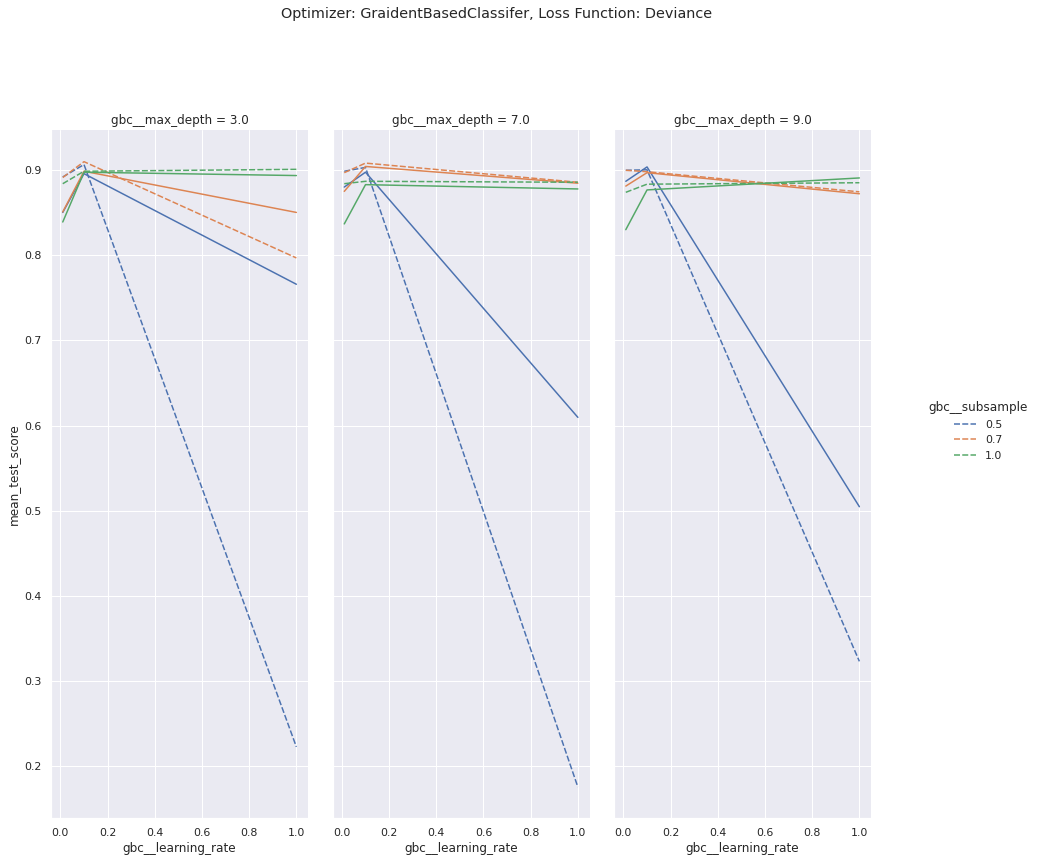

In [ ]:

gbc_sorted_subset2 = gbc_sorted.loc[(gbc_sorted['gbc__n_estimators'] == 500)]
grid = sns.FacetGrid(gbc_sorted, col = "gbc__max_depth" , hue ="gbc__subsample", col_wrap=3, sharey= True)
#grid.map(sns.scatterplot, "gbc__learning_rate", "mean_test_score")
grid.map_dataframe(sns.lineplot, "gbc__learning_rate", "mean_test_score", style = 'gbc__n_estimators')
grid.add_legend()
plt.gcf().set_size_inches(15, 15)
grid.fig.suptitle('Optimizer: GraidentTreeBoosting, Loss Function: Deviance')
plt.show()

**Conclusion on the hyperparamter tuning for GBC**

Learning rate of 1 causes the cost fuction to take drastic step changes leading to a divergent behavior and going past the minimal point. Learning rate of 0.01 does not reach the minimal point and the ideal learning rate is 0.1. The lower learning rate can be thought of as the fine grid tuning.

Gbc_subsample seems to have a significant impact on the model accuracy compared to the tree depth and the number of estimators.

At the selected learning rate of 0.1, the number of estimators ie. 100( dashed lines) and 500 (continous line) have miniscule difference in the accurcay error. 

Overall, the best performing gbc model has an accuracy score of 0.9033 as seen below. 

In [ ]:
ic(grid_search_GBC.best_params_)
ic(accuracy_score(grid_search_GBC.best_estimator_.predict(Xte_a), yte_a))

ic| grid_search_GBC.best_params_: {'gbc__learning_rate': 0.1,
                                   'gbc__max_depth': 3,
                                   'gbc__n_estimators': 500,
                                   'gbc__subsample': 0.7}
ic| accuracy_score(grid_search_GBC.best_estimator_.predict(Xte_a), yte_a): 0.903370786516854


0.903370786516854

In [ ]:
Tfidf_gbc = TfidfVectorizer(stop_words="english", strip_accents= ascii, max_features= 100)
doc_t_matrix_tr = Tfidf_gbc.fit_transform(Xtr_a)
gbc_best_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=29, subsample = 0.7).fit(doc_t_matrix_tr, ytr_a)

array([0.00488904, 0.00065411, 0.00481905, 0.00160521, 0.0035631 ,
       0.00343382, 0.00410027, 0.00434861, 0.01217331, 0.00399982,
       0.00533374, 0.00367766, 0.0081846 , 0.00166166, 0.03279878,
       0.00641121, 0.00416012, 0.00350591, 0.00314542, 0.02496912,
       0.00173823, 0.00058088, 0.02398193, 0.00869542, 0.00025219,
       0.00741865, 0.00128442, 0.0050084 , 0.00203889, 0.07041251,
       0.0151729 , 0.03418405, 0.02204014, 0.00069224, 0.00185753,
       0.0254867 , 0.00250707, 0.03761244, 0.00330721, 0.00377785,
       0.00413251, 0.00161814, 0.00273615, 0.00563678, 0.00150475,
       0.06051699, 0.00238808, 0.00423827, 0.00155995, 0.00094568,
       0.03885533, 0.00456431, 0.01779841, 0.00717499, 0.00342902,
       0.00337987, 0.02098992, 0.03964495, 0.00076498, 0.0038097 ,
       0.00591163, 0.00230917, 0.00717901, 0.00635864, 0.01067962,
       0.02164219, 0.01318013, 0.0021212 , 0.00124196, 0.0059558 ,
       0.01169349, 0.00275997, 0.00124243, 0.00133112, 0.01402

In [ ]:
import scipy.sparse
Tfidf_gbc.get_feature_names_out()

array(['000', '10', '2004', '2005', 'added', 'based', 'bbc', 'best',
       'blair', 'britain', 'british', 'brown', 'chief', 'come', 'company',
       'country', 'day', 'deal', 'did', 'digital', 'director', 'don',
       'economy', 'election', 'end', 'england', 'europe', 'european',
       'expected', 'film', 'firm', 'game', 'games', 'going', 'good',
       'government', 'group', 'growth', 'half', 'help', 'high', 'home',
       'industry', 'international', 'just', 'labour', 'like', 'london',
       'long', 'make', 'market', 'million', 'minister', 'mobile', 'money',
       'months', 'mr', 'music', 'need', 'net', 'new', 'news', 'nthe',
       'number', 'old', 'party', 'people', 'place', 'plans', 'play',
       'players', 'public', 'record', 'right', 'said', 'sales', 'say',
       'says', 'second', 'service', 'set', 'team', 'technology', 'think',
       'time', 'told', 'tv', 'uk', 'use', 'used', 'users', 'want', 'way',
       'week', 'win', 'won', 'work', 'world', 'year', 'years'],
      

,Feature_Names,Importance
90,users,0.073854
29,film,0.070413
45,labour,0.060517
94,win,0.045218
57,music,0.039645
50,market,0.038855
37,growth,0.037612
82,technology,0.037222
31,game,0.034184
14,company,0.032799


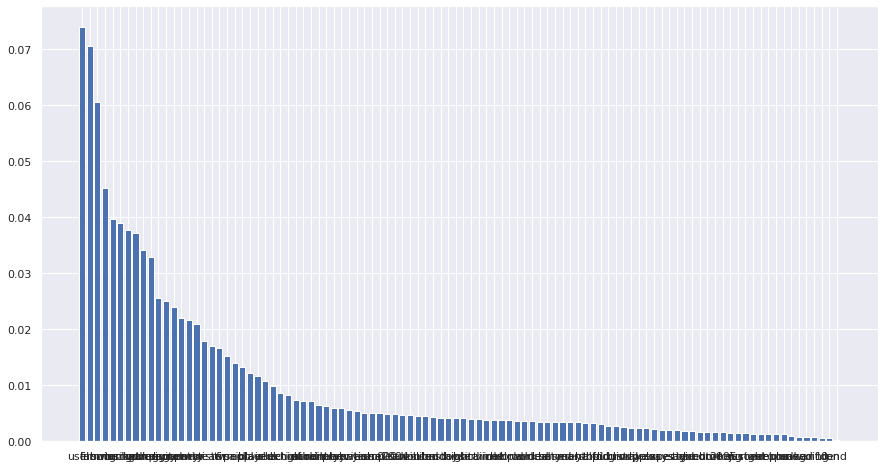

In [ ]:
gbc_feature_imp_df = pd.DataFrame({'Feature_Names': Tfidf_gbc.get_feature_names_out(), 'Importance': gbc_best_model.feature_importances_ }).sort_values(by = 'Importance', ascending = False)
plt.bar(gbc_feature_imp_df['Feature_Names'], gbc_feature_imp_df['Importance'])
gbc_feature_imp_df.head(20)

**Conclusion on the GBC model**

The top two features that lead to decrease in gini impurity are users at 7.3% and fiml at 7%. 

The GBC model accuracy on the test set is 0.9033.

### 4.1.5 Histogram Gradient Boosting Classifiers

**Introduction to HGBC and slected Hyperparameter tuning**

Gradient boosting is very slow to train. Training the trees by binning the continous input variables (which is why the document term matrix needs to be condensed) to a few hundred unique values. The maximum number of bins used for the non-missing value is 255, one bin is always reserved for missing values. 

The loss function for the HGBC model is categorical cross entropy. It is similar to the deviance loss fucntion of the Gradeint Boosting Random Forest Calssifier. 

As per scikit learn source code, the only difference between the two boosting algortims is the binning function of the input array in hgbc. 

**Hyperparameter tuned:**

Max_bins = The maximum number of bins to use for non-missing values. Before training, each feature of the input array X is binned into integer-valued bins, which allows for a much faster training stage. Features with a small number of unique values may use less than max_bins bins

Learning rate = Similar to the hyperparameter tuned for gbc



In [ ]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier
Tfidf_hist = TfidfVectorizer(stop_words="english", strip_accents= ascii, max_features = 100)
doc_matrix_tr_hist = Tfidf_hist.fit_transform(Xtr_a).todense() # A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
doc_matrix_te_hist = Tfidf_hist.transform(Xte_a).todense()

pipe_hgbc = Pipeline(steps = [("hgbc", HistGradientBoostingClassifier(random_state = 29))])

grid_hgbc = dict()
grid_hgbc['hgbc__learning_rate'] = [0.005, 0.01, 0.1, 1.0]
#grid_hgbc['hgbc__max_depth'] = [3, 7, 9, 12]
grid_hgbc['hgbc__max_bins'] = [100, 150, 255]                                

grid_search_HGBC = GridSearchCV(estimator=pipe_hgbc , param_grid=grid_hgbc, n_jobs=-1, cv=3, scoring='accuracy')

grid_result_HGBC = grid_search_HGBC.fit(doc_matrix_tr_hist, ytr_a)

print("Best: %f using %s" % (grid_result_HGBC.best_score_, grid_result_HGBC.best_params_))

means_HGBC = grid_result_HGBC.cv_results_['mean_test_score']
stds_HGBC = grid_result_HGBC.cv_results_['std_test_score']
params_HGBC = grid_result_HGBC.cv_results_['params']
for mean, stdev, param in zip(means_HGBC, stds_HGBC, params_HGBC):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Best: 0.912359 using {'hgbc__learning_rate': 0.1, 'hgbc__max_bins': 150}
0.847757 (0.005609) with: {'hgbc__learning_rate': 0.005, 'hgbc__max_bins': 100}
0.849443 (0.006944) with: {'hgbc__learning_rate': 0.005, 'hgbc__max_bins': 150}
0.848318 (0.004644) with: {'hgbc__learning_rate': 0.005, 'hgbc__max_bins': 255}
0.873595 (0.008262) with: {'hgbc__learning_rate': 0.01, 'hgbc__max_bins': 100}
0.870786 (0.002896) with: {'hgbc__learning_rate': 0.01, 'hgbc__max_bins': 150}
0.872471 (0.002896) with: {'hgbc__learning_rate': 0.01, 'hgbc__max_bins': 255}
0.908984 (0.006067) with: {'hgbc__learning_rate': 0.1, 'hgbc__max_bins': 100}
0.912359 (0.002420) with: {'hgbc__learning_rate': 0.1, 'hgbc__max_bins': 150}
0.905057 (0.001553) with: {'hgbc__learning_rate': 0.1, 'hgbc__max_bins': 255}
0.720136 (0.230210) with: {'hgbc__learning_rate': 1.0, 'hgbc__max_bins': 100}
0.476391 (0.022084) with: {'hgbc__learning_rate': 1.0, 'hgbc__max_bins': 150}
0.587073 (0.048767) with: {'hgbc__learning_rate': 1.0, 'hgbc

**Conclusion on HGBC**

The learning rate at 0.1 and the max_bins at 150 results in the highest accuracy on the training set at 0.912. 

Unlike the Random Forest Classifier and Gradient Boost Classifier, the histogram gradient boost classifier does not have the feature importance attribute. This could be simply because the words are randomly discritized into bins.

### 4.1.6 Scikit-Learn Supervised Model Conclusion

**4.1 Overall conclusion on scikit learn supervised model**


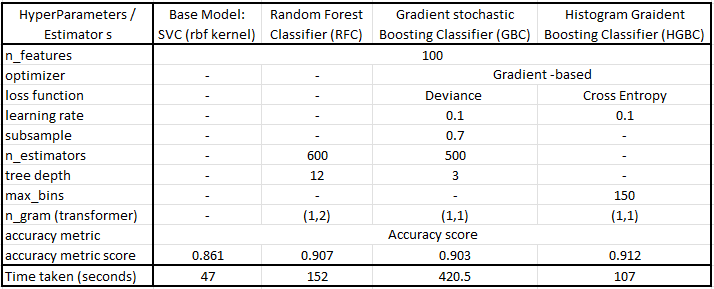



It is observed that among the scikit learn models,  the ensemble methods tend to perform on average 4% higher than SVC base model.  Since the dataset is balanced, and the classifiers have low variance, it is recommended to use boosting classifiers in our case either the gradient based classifier or histogram gradient based classifier. Although the bagging ensemble model, random forest regressor has a high accuracy metric, bagging ensemble methods are typically used for high variable and unstable classifier dataset.  The hgbc model tends to perform the best and converges in a much quicker time (even at extremely low learning rate). As such, the best selected scikit learn model is hgbc with an accuracy score of 0.912. 

Also notice that the feature importance is pretty similar across all the three (Ran scikit learn models 

Future work includes investigating non-differentiable loss functions for multi-classification datasets and using a document term matrix with more than 100 features


## 4.2 Word2Vec + Recursive Neural Network (RNN)

Bag of Word and TFIDF vectorization are frequency-based techniques. One word is represented one number. Word2Vec is a contextually aware vectorization method that take semantics into account. It uses a vector to represent a word. Words are mapped to n-dimensional space in such a manner that words having similar meanings exist in close proximity to one another.

RNN (Recursive Neural Network) is mainly used for a sequence of data, thus can be a good application for NLP since text has a sequential natural in order to express a certain meaning. RNN can memorize the information carried over by previous word.

In this section I'll stretch beyond a bit and see how combining Word2Vec and RNN works on text classification.

Data is split into train data (70%) and test data (30%) in stratified manner in order for model to learn equal amount of information  from each topic group.

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(df['text'], df['category'],test_size=0.3,stratify=df['category'], random_state=2022)

### 4.2.1 Preprocessing

Before model building, I did simple preprocessing on train data texts: tokenize, remove punctuation, convert upper case to lower case, remove stopwords. Now, each article has become a list of words.

In [ ]:
nltk.download('stopwords')
stop_word=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
texts_tokenized=[]
for text in x_train.tolist():
  text_tokenized=RegexpTokenizer(r'\w+').tokenize(text)
  text_tokenized=[word.lower() for word in text_tokenized]
  text_tokenized_stop=[word for word in text_tokenized if not word in stop_word]
  texts_tokenized.append(text_tokenized_stop)

Because label has 5 topics, I one hot encode the labels of train data label.

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.optimizers import *

y_train_encoded=LabelEncoder().fit_transform(y_train)
y_train_encoded = keras.utils.to_categorical(y_train_encoded, 5)

### 4.2.2 Word2Vec - Self-Trained

Word2Vec interprete semantics and calculate vector by looking at context words ahead and after a target word. Hyperparameter "window" allows adjustment on how many words ahead and after targeet words you want Word2Vec to consider. Hyperparameter "size" allows you adjust dimensions of vectors used to represent a word. 'min_count' is the minimum number of presence of a word in corpus above which it is included Word2Vec vocabulary.  

Here I initialize them as:  n_dim=300, window_size=10, method=1, min_count=10. 


In [ ]:
# Set Word2vec hyperparameters
n_dim=300
window_size=10
text_len=20
method=1
min_count=10

# Construct Word2vec model and weight matrix for embedding layer
w2vmodel= gensim.models.Word2Vec(sentences=texts_tokenized, window=window_size, size=n_dim, workers=4, sg=method, min_count=min_count)
embedding_matrix=w2vmodel.wv.vectors
embedding_matrix=np.vstack([ np.zeros(n_dim), embedding_matrix])

# Remove tokens that are not in Word2Vec vocabulary
tokens=[]
for line in range(len(texts_tokenized)):  
    tokens.append([word for word in texts_tokenized[line] if word in w2vmodel.wv.vocab.keys()])   


Each text has different length.To feed into neural network, text length needs to be unified. Those texts longer than the set length are truncated, while those shorters are padded with zeros at the end. I'll initialize text length, text_len=20.

In [ ]:
text_len=20
import plotly.graph_objects as go
token_length=[len(tokens[i]) for i in range(20)]
fig = go.Figure(go.Bar(
            x=token_length,
            orientation='h',
                          ))
fig.update_xaxes(title_text='Number of Tokens')
fig.add_vline(x=text_len, line_width=3, line_dash="dash", line_color="red")
fig.show()

In [ ]:
# Truncate texts longer than text_len, zero pad texts shorter than text_len
x_train_trunc=np.zeros((len(tokens), text_len))
for i in range(len(tokens)):
  for j in range(min( len(tokens[i]), text_len)):
    x_train_trunc[i,j]=w2vmodel.wv.vocab[tokens[i][j]].index+1

For the convenience of future use, write a function for Word2Vec model building process:

In [ ]:
def w2v (n_dim=300,window_size=10,text_len=20,method=1,min_count=10):

  # Construct Word2vec model and weight matrix for embedding layer
  w2vmodel= gensim.models.Word2Vec(sentences=texts_tokenized, window=window_size, size=n_dim, workers=4, sg=method, min_count=min_count)
  embedding_matrix=w2vmodel.wv.vectors
  embedding_matrix=np.vstack([ np.zeros(n_dim), embedding_matrix])

  # Remove tokens that are not in Word2Vec vocabulary
  tokens=[]
  for line in range(len(texts_tokenized)):  
      tokens.append([word for word in texts_tokenized[line] if word in w2vmodel.wv.vocab.keys()])   

  # Truncate texts longer than text_len, zero pad texts shorter than text_len
  x_train_trunc=np.zeros((len(tokens), text_len))
  for i in range(len(tokens)):
    for j in range(min( len(tokens[i]), text_len)):
      x_train_trunc[i,j]=w2vmodel.wv.vocab[tokens[i][j]].index+1

  return w2vmodel, embedding_matrix, x_train_trunc

Word2Vec model is now stored in variable 'w2vmodel'. An embedding layer is contructed to feed words in texts as vectors sequentially into a recursive neural network. Input of embedding layer is a sequence of tokens one hot encoded with length equal to number of words in vocabulary. The transpose of vector matrix output by Word2Vec model is used as weights in embedding layer. Thus output is sequence of n_dim dimentional vectors.

Next step is to contruct a network. Due to limited computation capability, I'll use a network with only one hidden layer. A softmax layer is added in the end to facilitate multi-class classification. Optimization method is SGD (Stochastic Gradient Descent). Hyperparameter needs to be tuned are number of nodes and learning rate.



### 4.2.3 Grid Search on Hyperparameters of RNN

Combining Word2Vec model and RNN together, I have two sets of hyparameters need to be tuned: one set from Word2Vec, the other from RNN. I firstly fixed the set from Word2Vec, and did gridsearch on RNN with 3 folds cross validation to find the combination of learning rate and nodes number that gives the highest accuracy. Then I fixed the RNN hyperparameters as the best combination and do grid search on that of Word2Vec simply using for loop.

In [ ]:
import os
os.environ['PYTHONHASHSEED'] = '0'
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import tensorflow as tf
import random as rn

# Set Word2vec hyperparameters fixed
n_dim=300
window_size=10
text_len=20
method=1
min_count=10

w2vmodel, embedding_matrix, x_train_trunc = w2v(n_dim=300,window_size=10,text_len=20,method=1,min_count=10)

np.random.seed(2022)
rn.seed(2022)
tf.random.set_seed(2022)

# Contruct a embedding layer + RNN
def nlp_model(nodes=64,lr=0.01):
  RNNmodel=keras.Sequential()
  embedding_layer=layers.Embedding( len(w2vmodel.wv.vocab)+1, n_dim, weights=[embedding_matrix], trainable=False)
  RNNmodel.add(embedding_layer)
  RNNmodel.add(layers.SimpleRNN(nodes))
  RNNmodel.add(layers.Dense(5, activation='softmax'))
  # RNNmodel.summary()
  opt=keras.optimizers.SGD(learning_rate=lr, decay=1e-6)
  RNNmodel.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
  return RNNmodel

# Grid search for best combination of nodes numbers and learning rate 
model = KerasClassifier(build_fn=nlp_model,epochs=10,verbose=0)
param_grid={'nodes':[128,200,256], 
            'lr':[0.001,0.005, 0.01]}            
search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
result=search.fit(x_train_trunc, y_train_encoded)

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Best: 0.915864 using {'lr': 0.005, 'nodes': 256}
0.729608 (0.036906) with: {'lr': 0.001, 'nodes': 128}
0.883751 (0.008665) with: {'lr': 0.001, 'nodes': 200}
0.897238 (0.000908) with: {'lr': 0.001, 'nodes': 256}
0.904945 (0.004541) with: {'lr': 0.005, 'nodes': 128}
0.906872 (0.009483) with: {'lr': 0.005, 'nodes': 200}
0.915864 (0.005057) with: {'lr': 0.005, 'nodes': 256}
0.910726 (0.011161) with: {'lr': 0.01, 'nodes': 128}
0.911368 (0.012586) with: {'lr': 0.01, 'nodes': 200}
0.909441 (0.019139) with: {'lr': 0.01, 'nodes': 256}


Learning rate of 0.005 and 256 nodes gives the highest average accuracy of 0.916. Then I fixed the learning rate and number of nodes, do grid search on Word2Vec hyperparameters using for loop.

### 4.2.4 Grid Search on Hyperparameters of Word2Vec

In [ ]:
# n_dim=300
# window_size=10
# text_len=20
method=1

nodes=256
lr=0.005
scores=np.zeros((3,3,3))
for u, n_dim in enumerate([100,200,300]):
  for v, window_size in enumerate([5,10,15]):
    for w, text_len in enumerate([10, 20, 40]):
      
      w2vmodel, embedding_matrix, x_train_trunc = w2v(n_dim,window_size,text_len,method=1,min_count=10)
      os.environ['PYTHONHASHSEED'] = '0'
      np.random.seed(2022)
      rn.seed(2022)
      tf.random.set_seed(2022)

      RNNmodel=keras.Sequential()
      embedding_layer=layers.Embedding( len(w2vmodel.wv.vocab)+1, n_dim, weights=[embedding_matrix], trainable=False)
      RNNmodel.add(embedding_layer)
      RNNmodel.add(layers.SimpleRNN(nodes))
      RNNmodel.add(layers.Dense(5, activation='softmax'))
      # RNNmodel.summary()
      opt=keras.optimizers.SGD(learning_rate=lr, decay=1e-6)
      RNNmodel.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
      res=RNNmodel.fit(x_train_trunc, y_train_encoded, epochs=10,verbose=0,validation_split=0.2)
      scores[u,v,w]=res.history['val_accuracy'][-1]
scores

array([[[0.88782054, 0.92307693, 0.93269229],
        [0.89102566, 0.91987181, 0.94551283],
        [0.90064102, 0.93910259, 0.95192307]],

       [[0.89102566, 0.91666669, 0.91346157],
        [0.89102566, 0.92948717, 0.93910259],
        [0.90384614, 0.91987181, 0.95192307]],

       [[0.88782054, 0.90384614, 0.92628205],
        [0.8974359 , 0.92628205, 0.92948717],
        [0.89423078, 0.92628205, 0.92307693]]])

In [ ]:
np.unravel_index(scores.argmax(), scores.shape)

(0, 2, 2)

Best hyperparameters combination :

n_dim=100, 
window_size=15, 
text_len=40, 
method=1, 
nodes=256, 
lr=0.005

### 4.2.5 Evaluate on Test Data

Build model with the best parameters found from above steps:

In [ ]:
n_dim=100
window_size=15
text_len=40
method=1
nodes=256
lr=0.005

w2vmodel, embedding_matrix, x_train_trunc = w2v(n_dim,window_size,text_len,method=1,min_count=10)

RNNmodel=keras.Sequential()
embedding_layer=layers.Embedding( len(w2vmodel.wv.vocab)+1, n_dim, weights=[embedding_matrix], trainable=False)
RNNmodel.add(embedding_layer)
RNNmodel.add(layers.SimpleRNN(nodes))
RNNmodel.add(layers.Dense(5, activation='softmax'))
# RNNmodel.summary()
opt=keras.optimizers.SGD(learning_rate=lr, decay=1e-6)
RNNmodel.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
res=RNNmodel.fit(x_train_trunc, y_train_encoded, epochs=10,verbose=0,validation_split=0.2)

Preprocess test data the same way as train data:

In [ ]:
tests_tokenized=[]
for text in x_test.tolist():
  text_tokenized=RegexpTokenizer(r'\w+').tokenize(text)
  text_tokenized=[word.lower() for word in text_tokenized]
  text_tokenized_stop=[word for word in text_tokenized if not word in stop_word]
  tests_tokenized.append(text_tokenized_stop)

test_tokens=[]
for line in range(len(tests_tokenized)):  
    test_tokens.append([word for word in tests_tokenized[line] if word in w2vmodel.wv.vocab.keys()])   

x_test_trunc=np.zeros((len(test_tokens), text_len))
for i in range(len(test_tokens)):
  for j in range(min( len(test_tokens[i]), text_len)):
    x_test_trunc[i,j]=w2vmodel.wv.vocab[test_tokens[i][j]].index+1  

In [ ]:
y_test_encoded=LabelEncoder().fit_transform(y_test)
y_test_encoded = keras.utils.to_categorical(y_test_encoded, 5)

In [ ]:
test_loss, test_acc=RNNmodel.evaluate(x_test_trunc,y_test_encoded,verbose=0)
test_acc

0.9446107745170593

Accuracy on test data is 0.944, outperforming conventional machine learning models in Scikit-Learn by around 4%.

### 4.2.6 Self-trained Word2Vec Model Visualization

In [ ]:
import sys
w2vmodel.most_similar('consumer')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('electronics', 0.8551876544952393),
 ('cea', 0.7798433303833008),
 ('technologies', 0.7569441795349121),
 ('reserve', 0.7537583112716675),
 ('ces', 0.7512387633323669),
 ('activity', 0.7482213377952576),
 ('manufacturing', 0.745251476764679),
 ('explosion', 0.7441971302032471),
 ('products', 0.7392041087150574),
 ('manufacturers', 0.7340000867843628)]

In [ ]:
w2vmodel.most_similar('mobile')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('phones', 0.8868014812469482),
 ('handsets', 0.8321526646614075),
 ('phone', 0.8269113302230835),
 ('operators', 0.8246983289718628),
 ('mobiles', 0.7970483303070068),
 ('3gsm', 0.7733418941497803),
 ('vodafone', 0.7726861238479614),
 ('3g', 0.7678889036178589),
 ('dating', 0.7543801069259644),
 ('operator', 0.7459267377853394)]

In [ ]:
w2vmodel.most_similar('simply')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('worry', 0.8508827686309814),
 ('seriously', 0.8424239158630371),
 ('nature', 0.8421298265457153),
 ('stem', 0.8373475670814514),
 ('danger', 0.8355730175971985),
 ('impossible', 0.8307989239692688),
 ('happening', 0.8294104933738708),
 ('walking', 0.8292842507362366),
 ('exactly', 0.8192929625511169),
 ('sheer', 0.8184750080108643)]

Word2Vec model can return similar words to target word. I randomly picked  'consumer','mobile','simply' as target word. The most similar word to 'consumer' is 'electronics','technology' and that of 'simply' is 'nature','seriously', which doesn't make a lot of sense. The most similar word to 'mobile' is 'phones', 'operator', which is easier to understand because phrases 'mobile phones' or 'mobile services operator' show up a lot in our daily language. 

In [ ]:
vocab=[]
matrix=np.zeros((len(w2vmodel.wv.vocab), n_dim))
for i, word in enumerate(w2vmodel.wv.vocab.keys()):
  vocab.append(word)
  matrix[i]=w2vmodel.wv.word_vec(word)

In [ ]:
showcase=pd.DataFrame(columns=['Word','Vector'])
showcase['Word']=vocab
showcase['Vector']=matrix

vec_ls=[]
for i, word in enumerate(w2vmodel.wv.vocab.keys()):
  vec_ls.append(matrix[i].round(3))
showcase['Vector']=vec_ls

In [ ]:
showcase[5:10]

,Word,Vector
5,uk,"[-0.399, -0.535, -0.214, 0.066, 0.157, 0.185, ..."
6,broadcaster,"[-0.332, -0.345, -0.286, -0.139, -0.193, -0.17..."
7,says,"[-0.17, 0.346, -0.486, 0.407, -0.122, 0.053, -..."
8,become,"[-0.36, -0.029, -0.186, 0.068, -0.011, -0.257,..."
9,first,"[-0.878, -0.116, -0.38, 0.004, -0.049, -0.04, ..."


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
word_list=['small','huge','simply','hard','mobile','phones','3g'] 
matrix_scaled=StandardScaler().fit_transform(matrix)
pca=PCA(n_components=3).fit(matrix_scaled)
matrix_pc=pca.transform(matrix_scaled)
matrix_pc=pd.DataFrame(matrix_pc,columns=['pc1','pc2','pc3'])
matrix_pc['vocab']=vocab
matrix_pc.head()

,pc1,pc2,pc3,vocab
0,-0.545799,-9.322501,2.410262,virgin
1,-0.046668,-1.408138,-4.370588,radio
2,-3.558957,-4.481051,0.238416,offers
3,-2.631751,-7.258281,0.049957,3g
4,-0.258374,-4.080333,-4.715258,broadcast


In [ ]:
matrix_pc=matrix_pc[matrix_pc.vocab.isin( word_list)]
matrix_pc

,pc1,pc2,pc3,vocab
3,-2.631751,-7.258281,0.049957,3g
53,-2.454704,2.671354,-1.668142,simply
59,-1.299861,-1.772053,0.532107,huge
76,-3.325261,-4.906167,-1.118504,mobile
450,-0.680129,-1.535114,-0.728675,hard
1481,-3.032150,-2.334113,-0.538025,small
1939,-3.735848,-4.840253,-2.787165,phones


In [ ]:
pca.explained_variance_ratio_

array([0.14570792, 0.10703963, 0.10149834])

In [ ]:
import plotly.express as px
fig = px.scatter_3d(matrix_pc, x=matrix_pc['pc1'], y=matrix_pc['pc2'], z=matrix_pc['pc3'],labels=dict(x="plot1", y="plot2",z='plot3'),text=matrix_pc.vocab)
fig.update_traces(textposition='top center')
fig.show()

Since Word2Vec map words into hyperspace, we can visualize them in a 3D space after dimension reduction. PCA dimension reduction to three retained 34% of information originally carried by 100-dimension vectors. Word 'small','huge','simply','hard','mobile','phones','3g' are mapped. Contrary to my expectation, the distance between "small" and "huge" are not comparable with that of "simply" and "hard". 'Phones' and '3g', both having high similarity with 'mobile' are far from each other. The reason of Word2Vec doesn't map words as good as I expected is I fed the model with corpus only available in this dataset. There are only over 5000 words in vocabulary, which is very limited. Thus, model learned limited information. To enhance model performance, Google’s pre-trained model is the best choice. It includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features. 

Despite the under-expected performance of self-trained Word2Vec model, accuracy of 0.944 is still considered high. It reveals the power of semantic-aware vectorization technique and neural network that considers the sequence nature of language.
 

### 4.2.7 Google Pre-trained Word2Vec Model Visualization

Now, let's look at Word2Vec model pre-trained model. To avoid Google colab session crash due to overlimit RAM usage, I import the first 15000 most frequent word vectors.  

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/Data607Project/word2vec-google-news-300.gz',binary=True,limit=15000) 


In [ ]:
model.most_similar('simply')

[('merely', 0.7094109654426575),
 ('either', 0.564945638179779),
 ('anyway', 0.564201831817627),
 ('actually', 0.5563552379608154),
 ('not', 0.5516793131828308),
 ('rather', 0.5407534241676331),
 ('instead', 0.5381818413734436),
 ('essentially', 0.5227806568145752),
 ('necessarily', 0.5213932394981384),
 ('easily', 0.4988102316856384)]

In [ ]:
model.most_similar('mobile')

[('mobile_phones', 0.7054649591445923),
 ('Mobile', 0.6691667437553406),
 ('smartphone', 0.6600653529167175),
 ('smartphones', 0.6404396295547485),
 ('handsets', 0.640427827835083),
 ('handset', 0.6366176605224609),
 ('wireless', 0.607456386089325),
 ('phones', 0.5943560600280762),
 ('cellphone', 0.5871524214744568),
 ('phone', 0.5593067407608032)]

In [ ]:
model.most_similar('consumer')

[('consumers', 0.7439895868301392),
 ('Consumer', 0.7379527688026428),
 ('Consumers', 0.5590105056762695),
 ('retail', 0.5538579225540161),
 ('consumer_electronics', 0.5020024180412292),
 ('customer', 0.4880543053150177),
 ('retailers', 0.47716423869132996),
 ('market', 0.46318989992141724),
 ('Retail', 0.4504684805870056),
 ('products', 0.4497535228729248)]

In google Word2Vec model, most similiar words to 'simply' is 'merely', that of  'mobile' is 'mobile_phone', 'smartphone', that of 'customer' is 'retail', 'customer', which makes a lot more sense now. 

In [ ]:
vocab_google=[]
matrix_google=np.zeros((len(model.wv.vocab), 300))
for i, word in enumerate(model.wv.vocab.keys()):
  vocab_google.append(word)
  matrix_google[i]=model.wv.word_vec(word)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
matrix_scaled=StandardScaler().fit_transform(matrix_google)
pca=PCA(n_components=3).fit(matrix_scaled)
matrix_pc_google=pca.transform(matrix_scaled)
matrix_pc_google=pd.DataFrame(matrix_pc_google,columns=['pc1','pc2','pc3'])
matrix_pc_google['vocab']=vocab_google
matrix_pc_google.head()

,pc1,pc2,pc3,vocab
0,-1.303735,0.006645,-0.631824,</s>
1,-2.179392,0.026148,-1.187861,in
2,-2.294609,0.537621,-0.983017,for
3,-1.467509,0.552266,-2.129054,that
4,-2.587361,0.904609,-0.487355,is


In [ ]:
matrix_pc_google=matrix_pc_google[matrix_pc_google.vocab.isin(word_list)]
matrix_pc_google

,pc1,pc2,pc3,vocab
387,-1.323095,-1.381263,-1.157043,hard
428,-1.959591,1.071562,-1.786968,small
1004,-2.312900,-0.170543,-1.246712,huge
1077,0.218196,2.073196,-0.883009,mobile
1197,-1.628311,0.300101,-2.620589,simply
4793,1.904552,1.181720,-1.400906,phones


In [ ]:
pca.explained_variance_ratio_

array([0.02027982, 0.01810932, 0.01686972])

In [ ]:
import plotly.express as px
fig = px.scatter_3d(matrix_pc_google, x=matrix_pc_google['pc1'], y=matrix_pc_google['pc2'], z=matrix_pc_google['pc3'],labels=dict(x="plot1", y="plot2",z='plot3'),text=matrix_pc_google.vocab)
fig.update_traces(textposition='top center')
fig.show()

I plot the same set of words in 3D space using vectors trained by Google. Distance between "small" and "huge" are comparable with that of "simply" and "hard". From both vocabulary similiarity and visualization, model trained by Google with massive corpus are closer to our understanding of language.

### 4.2.8 Google Pre-trained Model + RNN 

I fed the Google pre-trained model into RNN. This time I did not do gridsearch due to the lengthy running time. The combined model gives 93% of accuracy on test data. I'm confident that accuracy will be enhanced if any tuning is conducted, because the Google pre-trained model has more accurate understanding of vocabulary.

In [ ]:

text_len=40
method=1
nodes=256
lr=0.01

# # n_dim=100
# # window_size=15
# text_len=20
# method=1
# nodes=256
# lr=0.005

google_embedding_matrix=model.wv.vectors
# google_embedding_matrix=np.vstack([ np.zeros(n_dim), embedding_matrix])

tokens=[]
for line in range(len(texts_tokenized)):  
  tokens.append([word for word in texts_tokenized[line] if word in model.wv.vocab.keys()])

x_train_trunc_google=np.zeros((len(tokens), text_len))
for i in range(len(tokens)):
  for j in range(min( len(tokens[i]), text_len)):
    x_train_trunc_google[i,j]=model.wv.vocab[tokens[i][j]].index

tests_tokenized=[]
for text in x_test.tolist():
  text_tokenized=RegexpTokenizer(r'\w+').tokenize(text)
  text_tokenized=[word.lower() for word in text_tokenized]
  text_tokenized_stop=[word for word in text_tokenized if not word in stop_word]
  tests_tokenized.append(text_tokenized_stop)

test_tokens=[]
for line in range(len(tests_tokenized)):  
    test_tokens.append([word for word in tests_tokenized[line] if word in model.wv.vocab.keys()])   

x_test_trunc_google=np.zeros((len(test_tokens), text_len))
for i in range(len(test_tokens)):
  for j in range(min( len(test_tokens[i]), text_len)):
    x_test_trunc_google[i,j]=model.wv.vocab[test_tokens[i][j]].index

RNNmodel=keras.Sequential()
embedding_layer=layers.Embedding( len(model.wv.vocab), 300, weights=[google_embedding_matrix], trainable=False)
RNNmodel.add(embedding_layer)
RNNmodel.add(layers.SimpleRNN(nodes))
RNNmodel.add(layers.Dense(5, activation='softmax'))
# RNNmodel.summary()
opt=keras.optimizers.SGD(learning_rate=lr, decay=1e-6)
RNNmodel.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
res=RNNmodel.fit(x_train_trunc_google, y_train_encoded, epochs=20,verbose=0,validation_split=0.2)

test_loss, test_acc=RNNmodel.evaluate(x_test_trunc_google,y_test_encoded,verbose=0)
test_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).

0.93113774061203

# **5. Texts Labelling - Unsupervised Learning**

To label texts, we'll apply the Topic Modelling from unsupervised learning. The reason is unsupervised learning is easier for solving the problem by learning the data and classifying it without any labels. Also it's less complexity compared to the supervised learning. There are Clustering and Topic Modelling for unsupervised learning. Since clustering seeks to establish groups of documents within a corpus, and topic modelling aims to abstract core themes from a set of words. So we choose Topic Modelling for this question.

## 5.1 Preprocessing

First, we read the data from files, and excluding the category column.

In [ ]:
df_l=pd.DataFrame(columns=['text'])
cates=['business', 'entertainment','politics','sport','tech']
texts=[]

for cate in cates:
  path=f"/content/drive/MyDrive/Colab Notebooks/Data607Project/bbc-fulltext (document classification)/bbc/{cate}/"
  files = glob.glob(path+'*.txt')
  for file in files:
    with open(file,encoding='utf-8',errors='ignore') as f:
      text = f.read()       
      texts.append(text)
      
df_l['text']=texts

df_l.head()

,text
0,Dollar gains on Greenspan speech\n\nThe dollar...
1,Ad sales boost Time Warner profit\n\nQuarterly...
2,Yukos unit buyer faces loan claim\n\nThe owner...
3,High fuel prices hit BA's profits\n\nBritish A...
4,Japan narrowly escapes recession\n\nJapan's ec...


Here we clean the text, like removing punctuation, stop words and newlines, factoring bigrams, and Lemmatization.

In [ ]:
# Clean the text
stop_words=set(nltk.corpus.stopwords.words('english'))

def clean_text(headline):
  le=WordNetLemmatizer()
  word_tokens=word_tokenize(headline)
  tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
  cleaned_text=" ".join(tokens)
  return cleaned_text

df_l['cleaned_text']=df_l['text'].apply(clean_text)
df_l.drop(['text'],axis=1,inplace=True)

In [ ]:
data = df_l.cleaned_text.values.tolist()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))
print(data_words[:1])

[['dollar', 'gain', 'greenspan', 'speech', 'dollar', 'highest', 'level', 'euro', 'almost', 'three', 'month', 'federal', 'reserve', 'head', 'said', 'trade', 'deficit', 'stabilise', 'alan', 'greenspan', 'highlighted', 'government', 'willingness', 'curb', 'spending', 'rising', 'household', 'saving', 'factor', 'help', 'reduce', 'late', 'trading', 'york', 'dollar', 'reached', 'euro', 'thursday', 'market', 'concern', 'deficit', 'greenback', 'recent', 'month', 'friday', 'federal', 'reserve', 'chairman', 'greenspan', 'speech', 'london', 'ahead', 'meeting', 'finance', 'minister', 'sent', 'dollar', 'higher', 'earlier', 'tumbled', 'back', 'worse', 'than', 'expected', 'job', 'data', 'think', 'chairman', 'taking', 'much', 'sanguine', 'view', 'current', 'account', 'deficit', 'taken', 'time', 'said', 'robert', 'sinche', 'head', 'currency', 'strategy', 'bank', 'america', 'york', 'taking', 'longer', 'term', 'view', 'laying', 'condition', 'current', 'account', 'deficit', 'improve', 'year', 'next', 'worr

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words = make_bigrams(data_words)
data_words = make_trigrams(data_words)

In [ ]:
dictionary = corpora.Dictionary(data_words)
corpus = [dictionary.doc2bow(text) for text in data_words]
n_topics = range(1, 11)

In [ ]:
def printCoherenceScore(numTopics, scores, title):
  fig = plt.figure(figsize=(15, 5))
  plt.plot(numTopics, scores)
  plt.ylabel('Coherence Score')
  plt.xlabel('Number of Topics')
  plt.xticks(np.arange(min(numTopics), max(numTopics)+1, 1.0))
  plt.title('Coherence Score vs Number of Topics for ' + str(title))
  plt.show()

We use Coherence Score here to evaluate the best number of topics. Coherence Score measures how interpretable the topics are to humans. In this case, topics are represented as the top N words with the highest probability of belonging to that particular topic. Briefly, the coherence score measures how similar these words are to each other. There are some other ways to evaluate the topic model, such as Perplexity (A statistical measure of how well a probability model predicts a sample), and Silhouette Coefficient (treating topics as clusters and then applying Silhouette Coefficient to measure the similarity within each topic and dissimilarity between all the topics).

Basic assumptions on which all topic modelling algorithms are based:

Each document consists of more than one topics.

Each topic consists of a collection of words.

## 5.2 Latent Dirichlet Allocation

It's the generative probabilistic model topics are represented as the probability that each of a given set of terms will occur. A unique feature of LDA models is that topics are not required to be distinct, and words may occur in multiple topics; this allows for a kind of topical fuzziness that is useful for handling the flexibility of language.

LDA assumes each document has multiple topics.
Works best with longer texts such as full articles, essays, and books.

In [ ]:
def learn_lda_model(corpus, dictionary, k):
    lda = LdaModel(corpus, 
               id2word = dictionary,
               num_topics=k,                
               iterations=100,    
               random_state = 42,           
               per_word_topics=False)
    cm = CoherenceModel(model=lda, corpus=corpus, texts=data_words, coherence='c_v')
    coherence = cm.get_coherence()
    print('{}: {}'.format(k, coherence))
    return coherence

n_topics = range(1, 11)
lda_scores = [learn_lda_model(corpus, dictionary, k) for k in n_topics]

1: 0.32682193982680996
2: 0.4151399655943264
3: 0.4247518032608162
4: 0.4341169783389597
5: 0.4410994407979135
6: 0.377182418608818
7: 0.39849792957047464
8: 0.39678051334624376
9: 0.37804306992430364
10: 0.38226727512509734


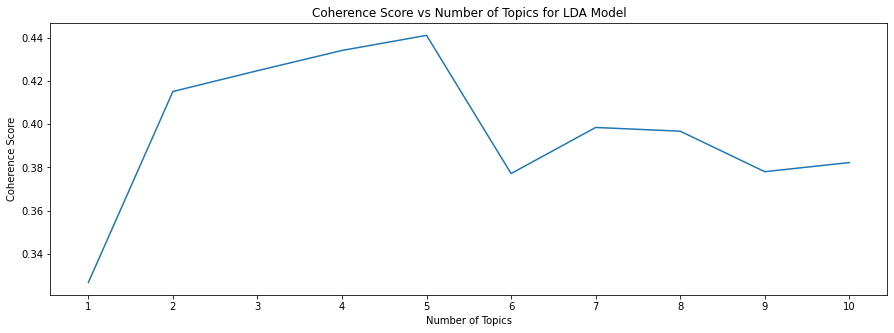

In [ ]:
printCoherenceScore(n_topics, lda_scores, "LDA Model")

From the plot graph, we could see 5 is the best number of topics, which is the right number.

In [ ]:
ldaModel = LdaModel(corpus, 
               id2word = dictionary,
               num_topics=5,                
               iterations=100,    
               random_state = 42,               
               per_word_topics=False)


We print out all the five topics, and top 10 highest probability words for each topic.

In [ ]:
for i in range(0, ldaModel.num_topics):
  print("Topic ", i)
  print(ldaModel.print_topic(i))
  print("\n")

Topic  0
0.015*"said" + 0.008*"music" + 0.008*"people" + 0.007*"technology" + 0.007*"mobile" + 0.006*"game" + 0.005*"year" + 0.005*"also" + 0.005*"service" + 0.005*"digital"


Topic  1
0.018*"said" + 0.011*"people" + 0.007*"user" + 0.007*"site" + 0.006*"would" + 0.006*"software" + 0.006*"also" + 0.005*"could" + 0.005*"microsoft" + 0.005*"firm"


Topic  2
0.022*"said" + 0.011*"people" + 0.006*"year" + 0.006*"also" + 0.005*"mobile" + 0.004*"would" + 0.004*"technology" + 0.004*"used" + 0.004*"number" + 0.003*"could"


Topic  3
0.017*"game" + 0.011*"said" + 0.007*"year" + 0.006*"also" + 0.005*"first" + 0.004*"time" + 0.004*"title" + 0.004*"would" + 0.004*"console" + 0.004*"world"


Topic  4
0.011*"said" + 0.008*"year" + 0.006*"virus" + 0.006*"could" + 0.005*"laptop" + 0.005*"would" + 0.004*"people" + 0.004*"security" + 0.004*"firm" + 0.004*"make"




Print out five documents, and probability of the topics it contains.

In [ ]:
for i in range(0, 5):
  print("Document :", i)

  ldaDocTopic = ldaModel.get_document_topics(corpus)[i]

  for k, v in ldaDocTopic:
    print("Topic ", k, ":  ", v*100,"%")
  
  print("\n")


Document : 0
Topic  2 :   99.58558082580566 %


Document : 1
Topic  1 :   3.0024243518710136 %
Topic  2 :   84.26952958106995 %
Topic  3 :   5.682184174656868 %
Topic  4 :   6.949322670698166 %


Document : 2
Topic  3 :   13.572680950164795 %
Topic  4 :   85.98144054412842 %


Document : 3
Topic  2 :   99.62263703346252 %


Document : 4
Topic  0 :   41.546764969825745 %
Topic  2 :   56.22909665107727 %
Topic  3 :   1.827486976981163 %




## 5.3 Latent Semantic Analysis

Sometimes machines would not be able to capture the concept as they cannot understand the context in which the words have been used. 

For exmple, 
Her favorite fruit to eat is a date.
He took her out on a date.

This is where the role of Latent Semantic Analysis (LSA) comes into the picture!
LSA tries to leverage the context around the words to capture the hidden or latent concepts, which are called topics.

Usually LSA is quick and efficient to use, but it needs a really large set of documents and vocabulary to get accurate results.

In [ ]:
PYTHONHASHSEED=0
def learn_lsa_model(corpus, dictionary, k):
    lsa = LsiModel(corpus, 
               id2word = dictionary,
               num_topics=k,                  
               power_iters=100)
    cm = CoherenceModel(model=lsa, corpus=corpus, texts=data_words, coherence='c_v')
    coherence = cm.get_coherence()
    print('{}: {}'.format(k, coherence))
    return coherence

n_topics = range(1, 11)
lsa_scores = [learn_lsa_model(corpus, dictionary, k) for k in n_topics]

1: 0.18676501267932766
2: 0.3509567131856685
3: 0.3576058993666889
4: 0.3798444120012914
5: 0.3261372999976239
6: 0.30778900911872553


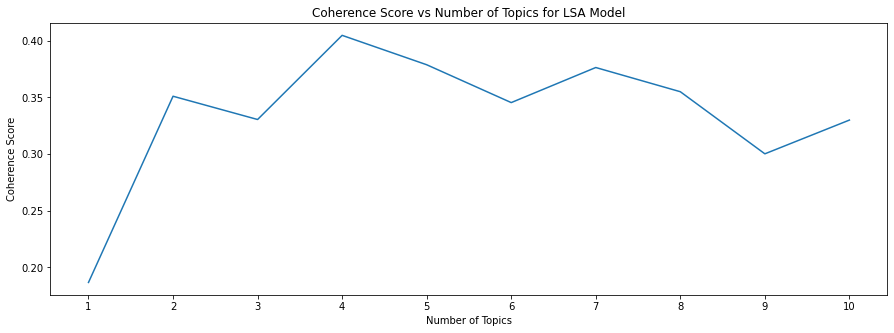

In [ ]:
printCoherenceScore(n_topics, lsa_scores, "LSA Model")

From the Coherence Score, although it changes every run. But we could see 4, 5 always have the highest score, and 5 happens more often. So we will choose 5 here, which is the same as our category.

In [ ]:
lsaModel = LsiModel(corpus, 
                    id2word = dictionary,
                    num_topics=5,                  
                    power_iters=100)

We print out all the five topics, and top 10 highest probability words for each topic for LSA model.

In [ ]:
for i in range(0, lsaModel.num_topics):
  print("Topic ", i)
  print(lsaModel.print_topic(i))
  print("\n")

Topic  0
0.556*"said" + 0.237*"year" + 0.226*"would" + 0.207*"people" + 0.148*"also" + 0.125*"could" + 0.118*"time" + 0.116*"game" + 0.114*"government" + 0.096*"music"


Topic  1
-0.447*"said" + 0.334*"best" + 0.326*"song" + 0.304*"music" + 0.248*"year" + 0.184*"game" + 0.149*"award" + 0.119*"angels" + 0.118*"last" + 0.103*"like"


Topic  2
0.609*"game" + -0.256*"song" + -0.226*"best" + -0.209*"music" + 0.157*"time" + -0.137*"said" + 0.130*"player" + -0.122*"year" + 0.120*"play" + 0.105*"world"


Topic  3
0.397*"music" + 0.320*"people" + -0.199*"year" + 0.197*"mobile" + 0.197*"technology" + -0.175*"best" + 0.155*"service" + 0.146*"urban" + 0.132*"phone" + -0.120*"game"


Topic  4
0.307*"said" + -0.282*"party" + -0.264*"labour" + -0.237*"government" + -0.208*"people" + -0.202*"would" + 0.188*"film" + 0.165*"year" + -0.162*"election" + 0.137*"firm"




## 5.4 Non-Negative Matrix Factorization

NMF a statistical method that helps us to reduce the dimension of the input corpora or corpora. Internally, it uses the factor analysis method to give comparatively less weightage to the words that are having less coherence. In another word, it calculates how well each document fits each topic, rather than assuming a
document has multiple topics.
Usually faster.
Works best with shorter texts such as tweets or titles.

In [ ]:
def learn_nmf_model(corpus, dictionary, k):
    nmf = Nmf(corpus, 
              id2word = dictionary,
              random_state = 42,  
              num_topics=k)
    cm = CoherenceModel(model=nmf, corpus=corpus, texts=data_words, coherence='c_v')
    coherence = cm.get_coherence()
    print('{}: {}'.format(k, coherence))
    return coherence

nmf_scores = [learn_nmf_model(corpus, dictionary, k) for k in n_topics]

1: 0.21422852485962754
2: 0.3090845367463616
3: 0.32142866013600696
4: 0.3223618824175696
5: 0.29936669465620086
6: 0.2803883872647974
7: 0.32892184468875413
8: 0.27596621252186077
9: 0.28927590414084453
10: 0.33566831202639624


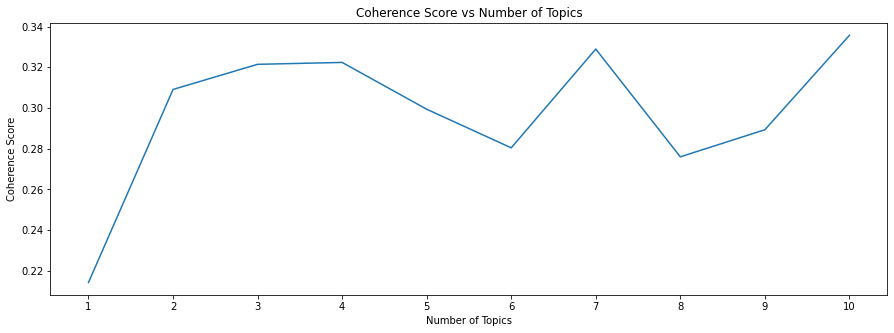

In [ ]:
printCoherenceScore(n_topics, nmf_scores, "NMF Model")

From the NMF model plot graph, we could see 7 is the best number of topics, which is different from the number of topics we knew.

In [ ]:
nmfModel = Nmf(corpus, 
              id2word = dictionary,
              random_state = 42,  
              num_topics=7)

We still print out all the topics, and top 10 highest probability words for each topic.

In [ ]:
for i in range(0, nmfModel.num_topics):
  print("Topic ", i)
  print(nmfModel.print_topic(i))
  print("\n")

Topic  0
0.013*"music" + 0.010*"song" + 0.010*"best" + 0.008*"year" + 0.007*"also" + 0.006*"british" + 0.005*"people" + 0.005*"think" + 0.005*"like" + 0.005*"award"


Topic  1
0.030*"game" + 0.010*"people" + 0.008*"year" + 0.007*"like" + 0.006*"time" + 0.005*"make" + 0.005*"play" + 0.004*"could" + 0.004*"world" + 0.004*"film"


Topic  2
0.009*"first" + 0.008*"music" + 0.008*"year" + 0.006*"world" + 0.005*"time" + 0.005*"sale" + 0.005*"company" + 0.005*"firm" + 0.004*"month" + 0.004*"film"


Topic  3
0.012*"year" + 0.008*"first" + 0.007*"labour" + 0.007*"film" + 0.006*"time" + 0.006*"back" + 0.005*"could" + 0.005*"government" + 0.005*"second" + 0.005*"world"


Topic  4
0.017*"year" + 0.016*"said" + 0.013*"would" + 0.013*"best" + 0.012*"last" + 0.010*"song" + 0.007*"bn" + 0.007*"club" + 0.005*"think" + 0.004*"wales"


Topic  5
0.020*"said" + 0.009*"government" + 0.009*"party" + 0.008*"would" + 0.006*"show" + 0.005*"also" + 0.005*"labour" + 0.005*"election" + 0.004*"plan" + 0.004*"country

Print out five documents, and probability of the topics it contains.

In [ ]:
for i in range(0, 5):
  print("Document :", i)

  nmfDocTopic = nmfModel.get_document_topics(corpus)[i]

  for k, v in nmfDocTopic:
    print("Topic ", k, ":  ", v*100,"%")
  
  print("\n")

Document : 0
Topic  1 :   7.0758911714326285 %
Topic  2 :   29.54124655774483 %
Topic  3 :   14.533539891456531 %
Topic  4 :   19.49938404003196 %
Topic  5 :   14.804181756563075 %
Topic  6 :   14.545756582770967 %


Document : 1
Topic  2 :   47.387881835754634 %
Topic  4 :   24.06939054155307 %
Topic  5 :   3.9438620316383717 %
Topic  6 :   24.59886559105394 %


Document : 2
Topic  2 :   55.98800934600116 %
Topic  5 :   29.859401703467707 %
Topic  6 :   14.152588950531145 %


Document : 3
Topic  1 :   8.070945909366335 %
Topic  2 :   21.600865010601243 %
Topic  3 :   1.3405032785970599 %
Topic  4 :   46.974252785189115 %
Topic  5 :   8.338100904915116 %
Topic  6 :   13.675332111331148 %


Document : 4
Topic  2 :   28.387655553518197 %
Topic  4 :   7.872875438735218 %
Topic  5 :   34.688662106337475 %
Topic  6 :   29.05080690140911 %




At the end, we found LSA is the best algroithem for our dataset. Because we could easily find which topic is which category. 

Topic 1 is Business with words: "said, year, would, people, also, could, time, game, government, music".

Topic 2 is Entertainment with words: "said, best, song, music, year, game, award, angels, last, like".

Topic 3 is Sports with words: "game, song, best, music, time, said, player, year, play, world".

Topic 4 is Technology with words: "music, people, year, mobile, technology, best, service, urban, phone, game".

Topic 5 is Politics with words: "said, party, labour, government, people, would, film, year, election, firm".

References 

1. Wikimedia Foundation. (2022, April 3). BBC News. Wikipedia. Retrieved April 5, 2022, from https://en.wikipedia.org/wiki/BBC_News.
2. Text classification of news articles. Analytics Vidhya. (2021, December 27). Retrieved April 5, 2022, from https://www.analyticsvidhya.com/blog/2021/12/text-classification-of-news-articles/.

